# Emitting Spot Size measurement on 2020-02-07

## Load all the data

In [2]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

### Load from database

In [ ]:
# reference detectors
# dose
# HV
DAY = "2020-02-04"
# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)

# get reference detectors
query = "SELECT * FROM data_referenceDetectors WHERE DATE(time) > '2020-02-03 20:00:00'" 
data_reference_full = con.get_from_database(query=query)

# get microwave power
query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_power_full = con.get_from_database(query=query)

# get microwave frequency
query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_frequency_full = con.get_from_database(query=query)

# save to file
data_reference_full['sum_counts'] = data_reference_full['counts_D1'] + data_reference_full['counts_D2'] + data_reference_full['counts_D3'] + data_reference_full['counts_D4'] 

path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/emitting_spot_size_2020-02-04/'
data_dose.to_csv(f'{path}/2020-02-07_dose.csv')
data_hv.to_csv(f'{path}/2020-02-07_hv.csv')
data_pressure.to_csv(f'{path}/2020-02-07_pressure.csv')
data_reference_full.to_csv(f'{path}/2020-02-07_reference_detectors.csv')
data_microwave_power_full.to_csv(f'{path}/2020-02-07_microwave_power.csv')
data_microwave_frequency_full.to_csv(f'{path}/2020-02-07_microwave_frequency.csv')

### Load from stored csv files

In [3]:
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/emitting_spot_size_2020-02-04/'
DAY = "2020-02-04"

data_dose = pd.read_csv(f'{path}/2020-02-07_dose.csv', index_col=0)
data_dose.index = pd.to_datetime(data_dose.index)

data_hv = pd.read_csv(f'{path}/2020-02-07_hv.csv', index_col=0)
data_hv.index = pd.to_datetime(data_hv.index)

data_pressure = pd.read_csv(f'{path}/2020-02-07_pressure.csv', index_col=0)
data_pressure.index = pd.to_datetime(data_pressure.index)

data_reference_full = pd.read_csv(f'{path}/2020-02-07_reference_detectors.csv', index_col=0)
data_reference_full.index = pd.to_datetime(data_reference_full.index)

data_microwave_power_full = pd.read_csv(f'{path}/2020-02-07_microwave_power.csv', index_col=0)
data_microwave_power_full.index = pd.to_datetime(data_microwave_power_full.index)

data_microwave_frequency_full = pd.read_csv(f'{path}/2020-02-07_microwave_frequency.csv', index_col=0)
data_microwave_frequency_full.index = pd.to_datetime(data_microwave_frequency_full.index)


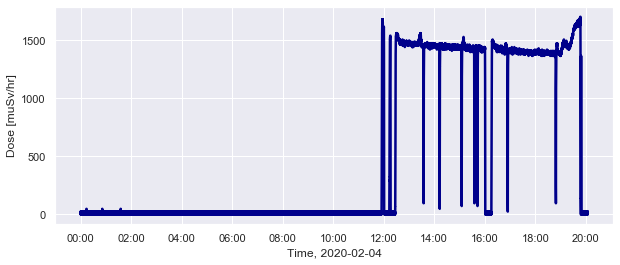

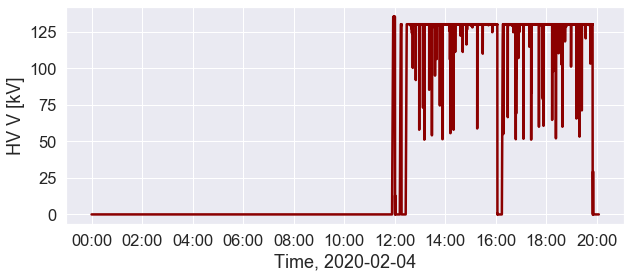

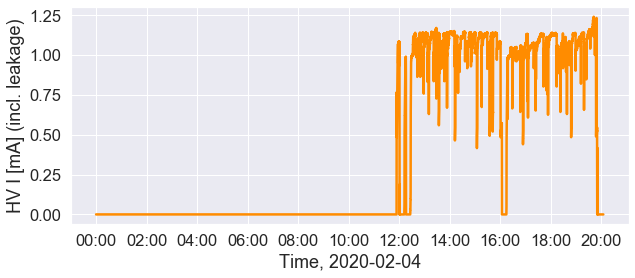

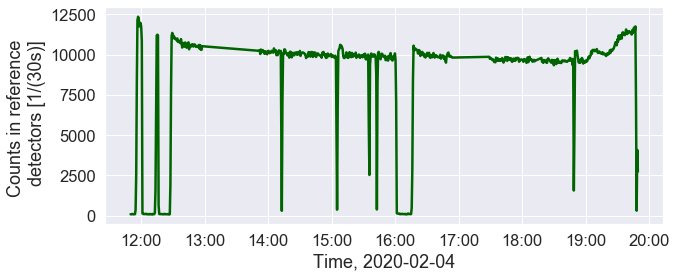

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_full.index, y='sum_counts', data=data_reference_full, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

#### Select only relevant time

In [5]:
start = "2020-02-04 11:54:00"
end = "2020-02-04 20:00:00"

data_dose_s = data_dose.loc[start:end, ]
data_hv_s = data_hv.loc[start:end, ]
data_reference_s = data_reference_full.loc[start:end, ]


### Counts in emitting spot size detector

In [6]:
# tungsten counts
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-04.EmittingSpot_130kV/2020-02-04_readout.csv'
data_ess = pd.read_csv(fname, index_col='time')
data_ess = data_ess[['readtime', 'value']]
data_ess.index = pd.to_datetime(data_ess.index)
# background measurement use the one from the day before
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-01-30.EmittingSpot.Leadshield/2020-01-31_readout.csv'
data_ess_BG = pd.read_csv(fname, index_col='time')
data_ess_BG = data_ess_BG[['readtime', 'value']]
data_ess_BG.index = pd.to_datetime(data_ess_BG.index)
data_ess_BG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2020-01-30 18:47:39.153445 to 2020-01-31 07:40:25.190357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   readtime  1507 non-null   float64
 1   value     1507 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 35.3 KB


#### Background correction of emitting spot size detector and reference detector

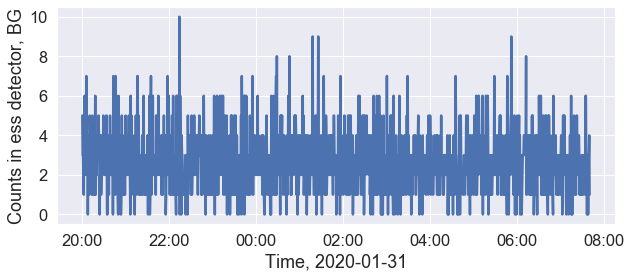

Mean background counts per 30 s interval: 2.688644688644689 1/(30s)
Mean background counts per second: 0.08905155963979494 1/s
Total counts: 3670
Total time duration: 0 days 11:40:22.783910
Total time duration: 42022 s
Total meas positions expected in that time: 1391.8256491785903 
Total measurement points: (1365, 2)
Total counts per time duration: 0.08733520536861644 1/s


In [7]:
start_BG = "2020-01-30 20:00:00"
end_BG = "2020-01-31 08:00:00"

data_ess_BG = data_ess_BG.loc[start_BG:end_BG, ]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess_BG.index, y='value', data=data_ess_BG, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in ess detector, BG')
ax.set_xlabel(f'Time, 2020-01-31')
plt.show()
print(f"Mean background counts per 30 s interval: {data_ess_BG.value.mean()} 1/(30s)")
counting_time = data_ess_BG['readtime'].value_counts().index[0]/1000
counts_per_s_BG = data_ess_BG.value.mean()/counting_time
print(f"Mean background counts per second: {counts_per_s_BG} 1/s")
print(f"Total counts: {data_ess_BG.value.sum()}")
timedelta = data_ess_BG.index[-1]-data_ess_BG.index[0] 
print(f"Total time duration: {timedelta}")
print(f"Total time duration: {timedelta.seconds} s")
print(f"Total meas positions expected in that time: {timedelta.seconds/counting_time} ")
print(f"Total measurement points: {data_ess_BG.shape}")
counts_per_s_BG_agg = data_ess_BG.value.sum()/timedelta.seconds
print(f"Total counts per time duration: {counts_per_s_BG_agg} 1/s")

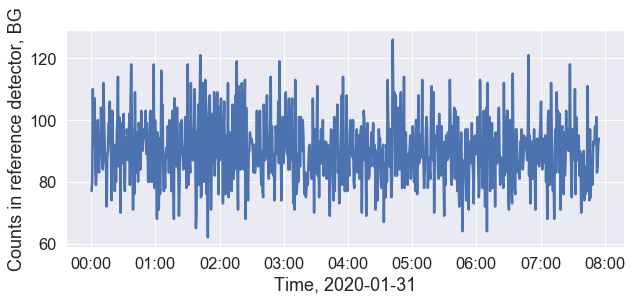

Mean background counts per 30 s interval: 90.21960297766749 1/(30s)
Mean background counts per second: 2.988195647114053 1/s
Total counts: 72717.0
Total time duration: 0 days 07:54:07.383517
Total time duration: 28447 s
Total meas positions expected in that time: 942.2032326444091 
Total measurement points: (806, 7)
Total counts per time duration: 2.5562273701972087 1/s


In [8]:
data_reference_full_BG = pd.read_csv(f'/Users/hkromer/02_PhD/02_Data/13.new_chamber/DATA/emitting_spot_size_2020-01-31//2020-02-07_reference_detectors.csv', index_col=0)
data_reference_full_BG.index = pd.to_datetime(data_reference_full_BG.index)
start_BG = "2020-01-30 20:00:00"
end_BG = "2020-01-31 07:55:00"

data_ref_BG = data_reference_full_BG.loc[start_BG:end_BG, ]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ref_BG.index, y='sum_counts', data=data_ref_BG, ax=ax)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference detector, BG')
ax.set_xlabel(f'Time, 2020-01-31')
plt.show()

print(f"Mean background counts per 30 s interval: {data_ref_BG.sum_counts.mean()} 1/(30s)")
ref_counting_time = data_ref_BG['ard_time'].value_counts().index[0]/1000
ref_counts_per_s_BG = data_ref_BG.sum_counts.mean()/counting_time
print(f"Mean background counts per second: {ref_counts_per_s_BG} 1/s")
print(f"Total counts: {data_ref_BG.sum_counts.sum()}")
timedelta = data_ref_BG.index[-1]-data_ref_BG.index[0] 
print(f"Total time duration: {timedelta}")
print(f"Total time duration: {timedelta.seconds} s")
print(f"Total meas positions expected in that time: {timedelta.seconds/counting_time} ")
print(f"Total measurement points: {data_ref_BG.shape}")
ref_counts_per_s_BG_agg = data_ref_BG.sum_counts.sum()/timedelta.seconds
print(f"Total counts per time duration: {ref_counts_per_s_BG_agg} 1/s")

### Tungsten edge position

In [9]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-04.EmittingSpotSize.xlsx' 
data_pos = pd.read_excel(fname, header=4)
data_pos = data_pos[['Time', 'Time.1', 'edge_pos']]
data_pos = data_pos.iloc[2:,:] # clear rows at beginning and end
data_pos['edge_pos'] = data_pos['edge_pos'].astype(np.float64)
data_pos['Time'] = data_pos['Time'].apply(lambda x: f'2020-02-04 {x}')
data_pos = data_pos.dropna()
data_pos['Time.1'] = data_pos['Time.1'].apply(lambda x: f'2020-02-04 {x}')
data_pos['Time'] = pd.to_datetime(data_pos['Time'])
data_pos['Time.1'] = pd.to_datetime(data_pos['Time.1'])

data_pos.reset_index(inplace=True, drop=True)
data_pos = data_pos.rename(columns={'Time': 'time_start', 'Time.1': 'time_stop'})


## Clean dose and ref counts

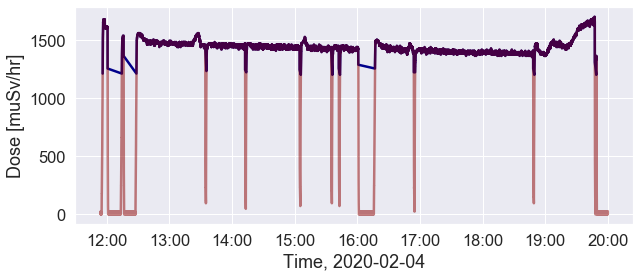

In [10]:
data_dose_s_temp = data_dose_s
# data_dose_s_temp['dose_corrected'] = data_dose_s_temp['dose_corrected'].rolling(100, win_type='gaussian').mean(std=10)
data_dose_s_temp = data_dose_s_temp[data_dose_s_temp['dose_corrected'] > 1200]
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
data_plot_t = data_dose_s_temp # .loc["2020-02-04 14:00:00":"2020-02-04 15:00:00",:]
sns.lineplot(x=data_plot_t.index, y='dose_corrected', data=data_plot_t, ax=ax, color='darkblue')
data_plot = data_dose_s # .loc["2020-02-04 14:00:00":"2020-02-04 15:00:00",:]
sns.lineplot(x=data_plot.index, y='dose_corrected', data=data_plot, ax=ax, color='darkred', alpha=0.5)

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


## Some plots - database

In [15]:
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

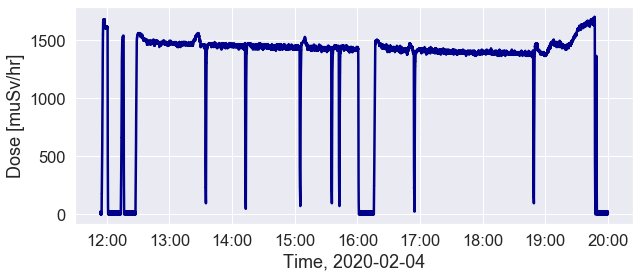

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

data_plot = data_dose_s # .loc["2020-02-04 14:00:00":"2020-02-04 15:00:00",:]
sns.lineplot(x=data_plot.index, y='dose_corrected', data=data_plot, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

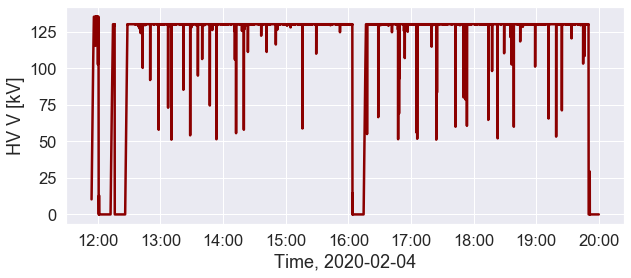

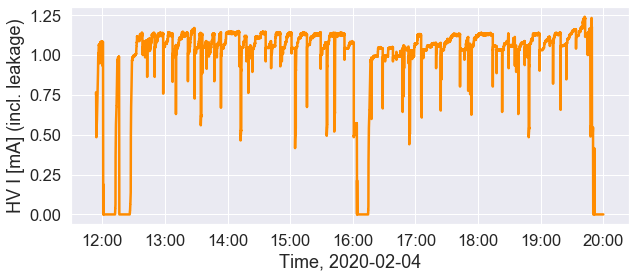

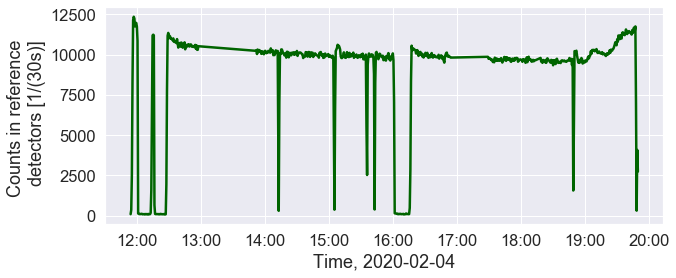

In [19]:

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_voltage', data=data_hv_s, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv_s.index, y='HV_current', data=data_hv_s, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_reference_s.index, y='sum_counts', data=data_reference_s, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in reference \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

## ESS

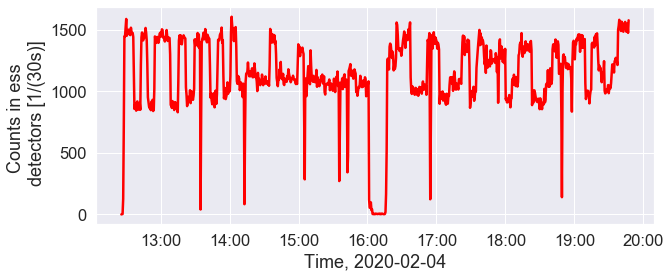

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_ess.index, y='value', data=data_ess, ax=ax, color='red')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Counts in ess \n detectors [1/(30s)]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

# Extract data for each tungsten position

### Tungsten edge position

In [21]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-04.EmittingSpotSize.xlsx' 
data_pos = pd.read_excel(fname, header=4)
data_pos = data_pos[['Time', 'Time.1', 'edge_pos']]
data_pos = data_pos.iloc[2:,:] # clear rows at beginning and end
data_pos['edge_pos'] = data_pos['edge_pos'].astype(np.float64)
data_pos['Time'] = data_pos['Time'].apply(lambda x: f'2020-02-04 {x}')
data_pos = data_pos.dropna()
data_pos['Time.1'] = data_pos['Time.1'].apply(lambda x: f'2020-02-04 {x}')
data_pos['Time'] = pd.to_datetime(data_pos['Time'])
data_pos['Time.1'] = pd.to_datetime(data_pos['Time.1'])

data_pos.reset_index(inplace=True, drop=True)
data_pos = data_pos.rename(columns={'Time': 'time_start', 'Time.1': 'time_stop'})



## Adjustments

In [22]:
# drop errorenous col
# data_pos.loc[data_pos['time_start'] > "2020-02-04 19:13:00"]
data_pos = data_pos.drop(55).reset_index(drop=True)
data_pos.tail(10)

time_start           time_stop  edge_pos
50 2020-02-04 18:40:40 2020-02-04 18:46:07     19.10
51 2020-02-04 18:52:00 2020-02-04 18:56:50     18.35
52 2020-02-04 18:58:00 2020-02-04 19:03:30     24.00
53 2020-02-04 19:03:30 2020-02-04 19:09:00     19.00
54 2020-02-04 19:09:10 2020-02-04 19:14:35     17.50
55 2020-02-04 19:14:45 2020-02-04 19:20:15     19.70
56 2020-02-04 19:20:20 2020-02-04 19:25:50     18.15
57 2020-02-04 19:25:58 2020-02-04 19:31:25     16.50
58 2020-02-04 19:31:50 2020-02-04 19:37:30     18.00
59 2020-02-04 19:37:45 2020-02-04 19:46:40     18.60

In [23]:
# # replace in t0
# dict_replace = {
#     pd.Timestamp('2020-01-31 13:52:00'): pd.Timestamp('2020-01-31 13:52:30'),
#     pd.Timestamp('2020-01-31 14:26:00'): pd.Timestamp('2020-01-31 14:28:00')
    
# }
# data_pos['t0'] = data_pos['t0'].replace(dict_replace)

# # replace in t1
# dict_replace = {
#     pd.Timestamp('2020-01-31 08:45:00'): pd.Timestamp('2020-01-31 08:43:00'),
#     pd.Timestamp('2020-01-31 13:36:00'): pd.Timestamp('2020-01-31 13:35:00')
# }
# data_pos['t1'] = data_pos['t1'].replace(dict_replace)

931.00, 840.00, 31.37


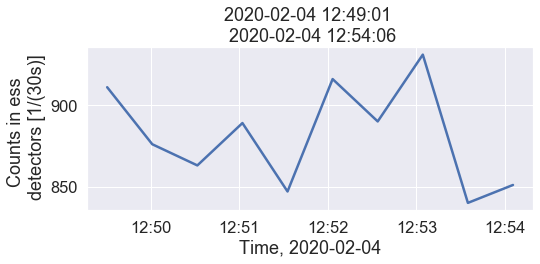

1476.00, 1393.00, 31.04


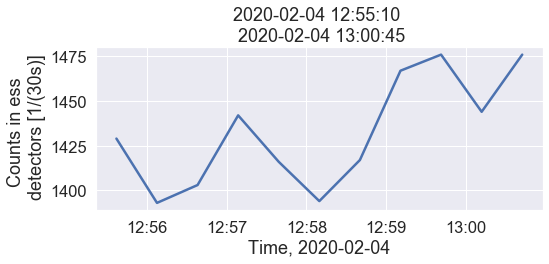

1504.00, 1405.00, 32.16


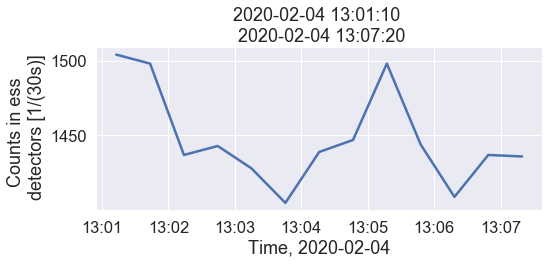

921.00, 830.00, 26.97


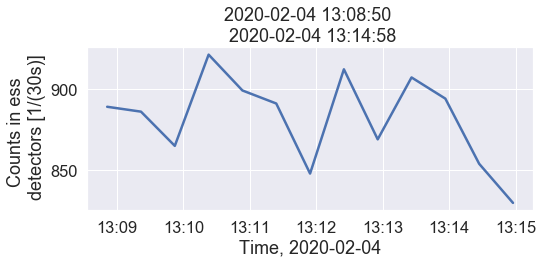

1455.00, 1081.00, 98.81


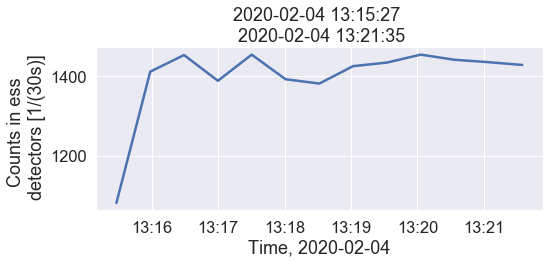

1033.00, 880.00, 46.22


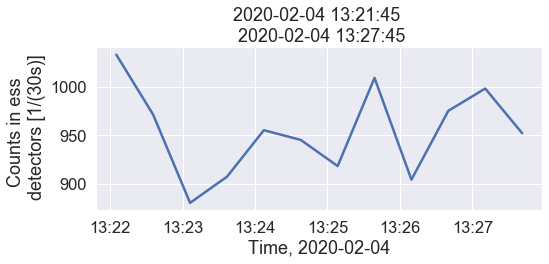

1506.00, 1398.00, 30.87


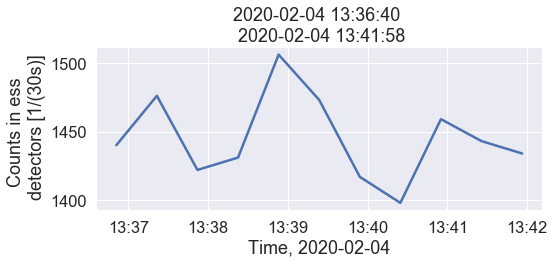

1006.00, 870.00, 46.46


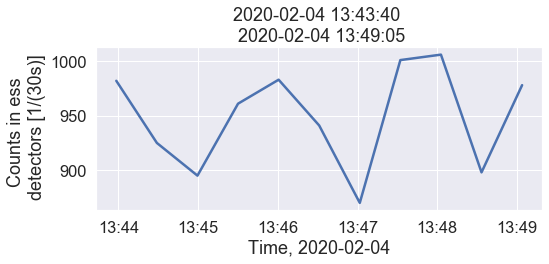

1518.00, 1191.00, 87.86


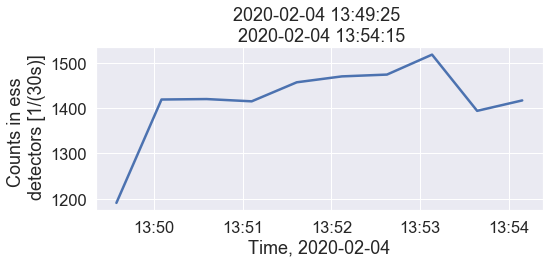

1073.00, 937.00, 39.99


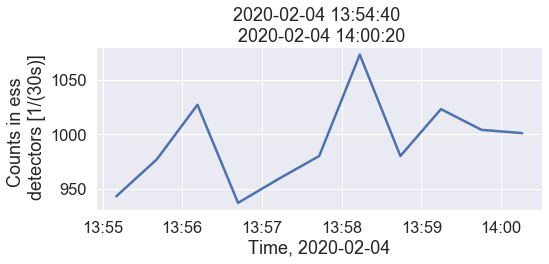

1606.00, 1125.00, 127.00


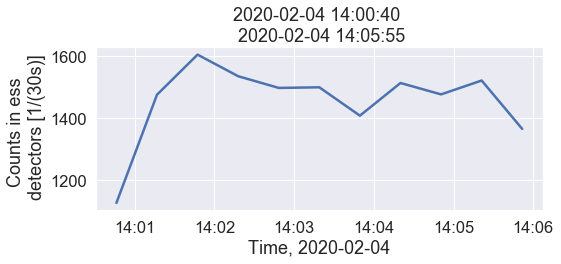

1125.00, 953.00, 51.80


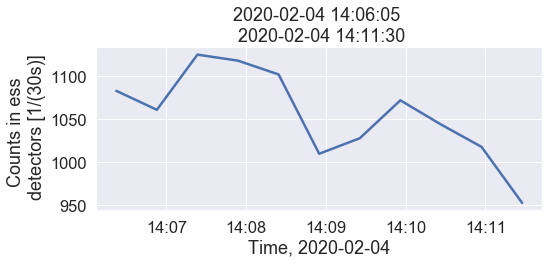

1227.00, 1114.00, 34.20


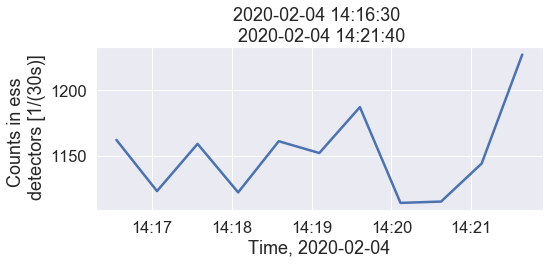

1150.00, 1002.00, 40.58


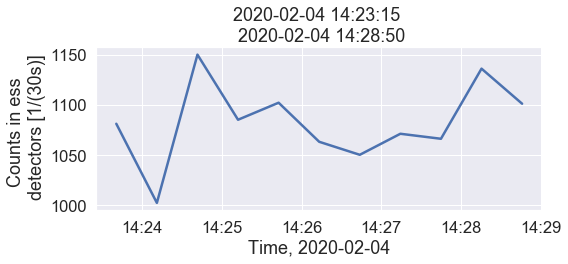

1121.00, 1045.00, 22.11


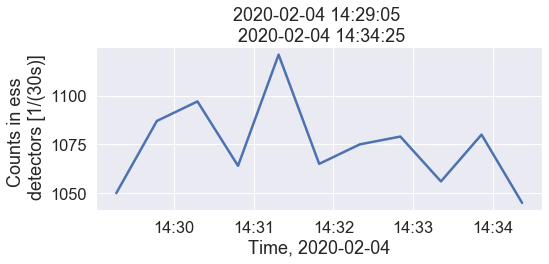

1507.00, 1210.00, 78.96


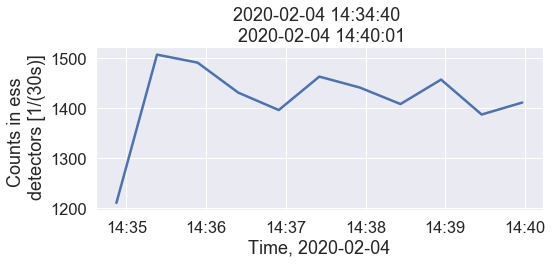

1239.00, 1042.00, 58.09


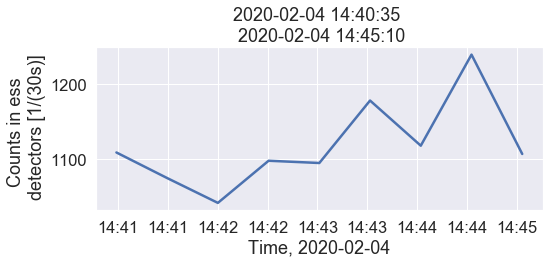

1179.00, 1074.00, 31.15


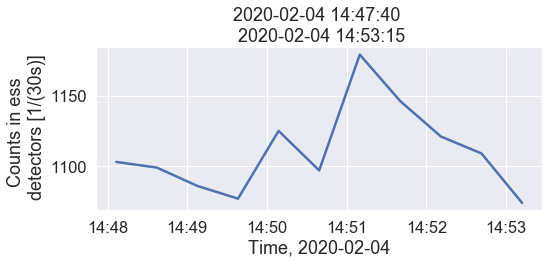

1127.00, 1059.00, 22.35


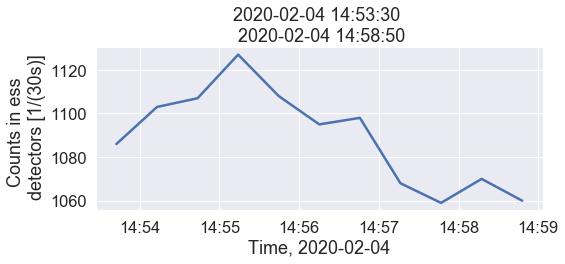

1382.00, 1228.00, 43.37


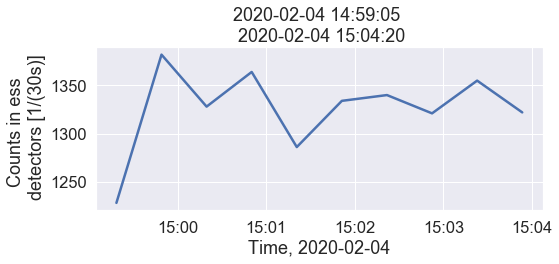

1333.00, 1058.00, 79.69


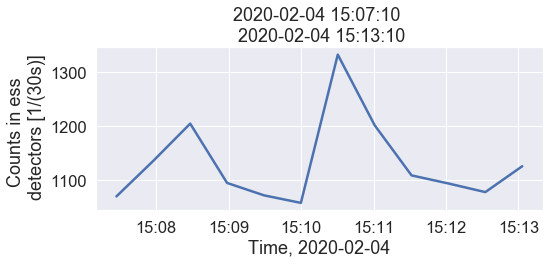

1174.00, 1037.00, 34.45


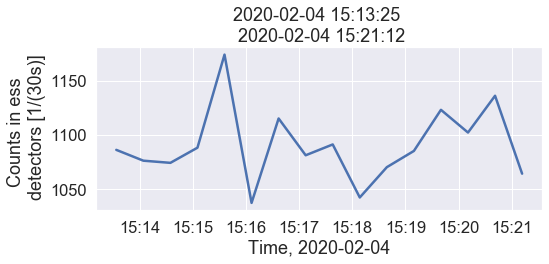

1122.00, 974.00, 42.01


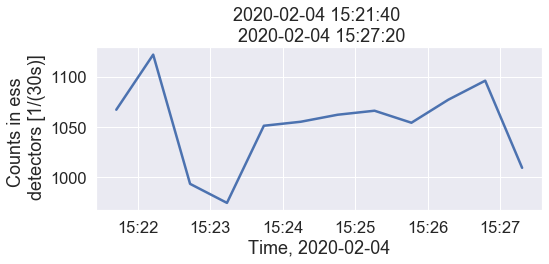

1118.00, 994.00, 38.47


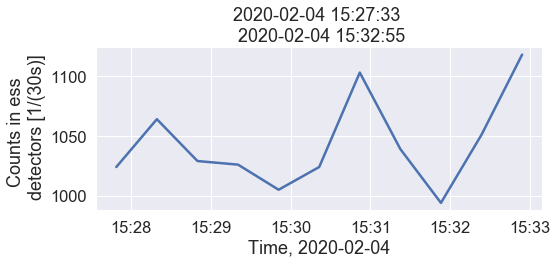

1138.00, 1018.00, 39.54


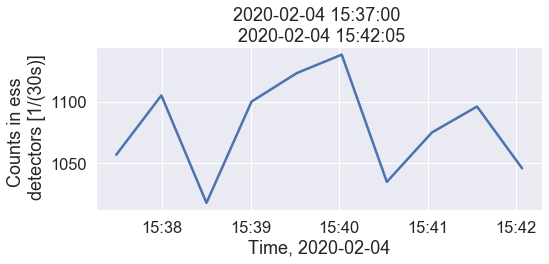

1221.00, 1103.00, 35.53


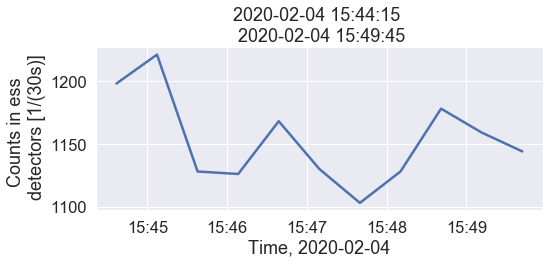

1126.00, 964.00, 42.34


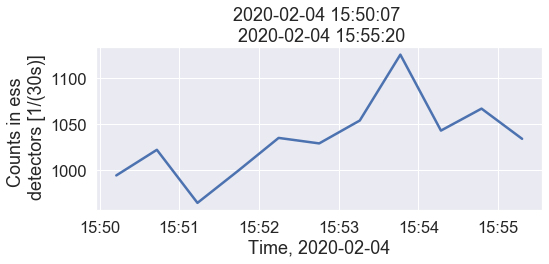

1114.00, 960.00, 46.32


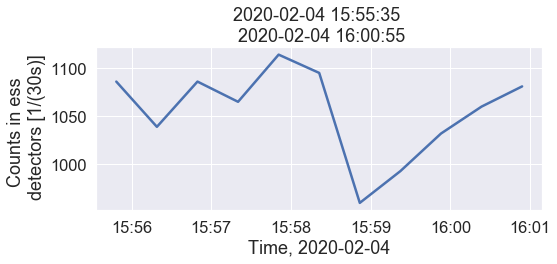

1378.00, 1170.00, 68.48


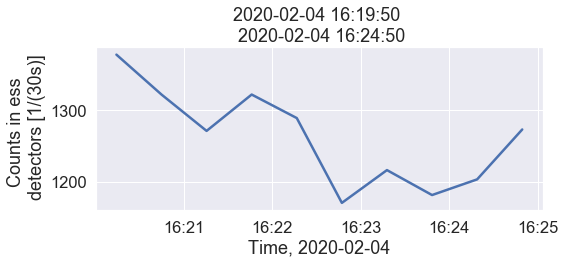

1559.00, 1289.00, 90.06


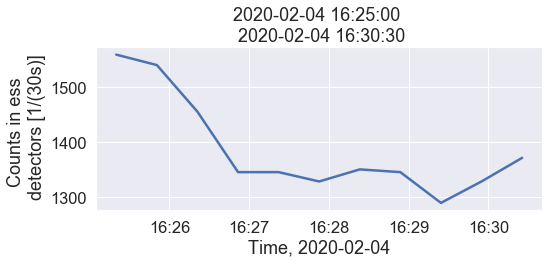

1510.00, 1353.00, 45.13


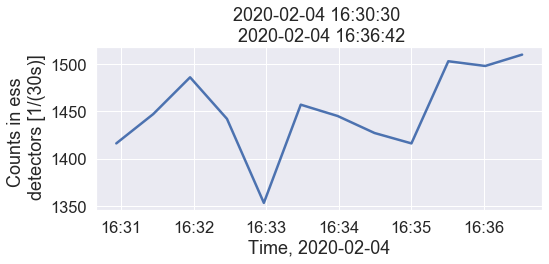

1114.00, 972.00, 37.17


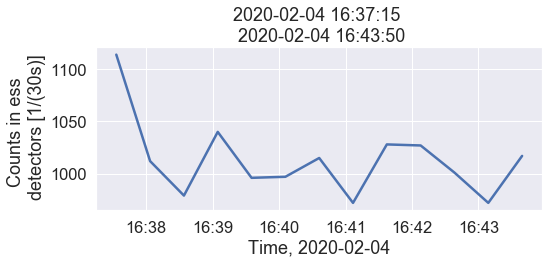

1080.00, 964.00, 31.99


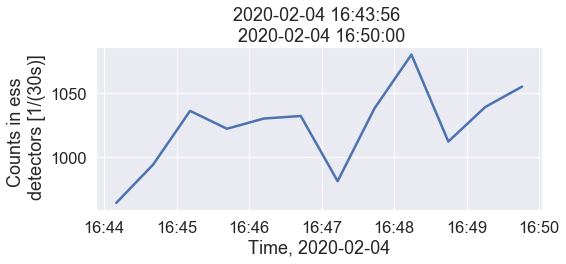

1480.00, 1347.00, 36.34


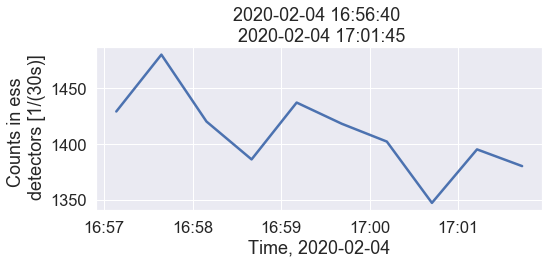

999.00, 891.00, 33.79


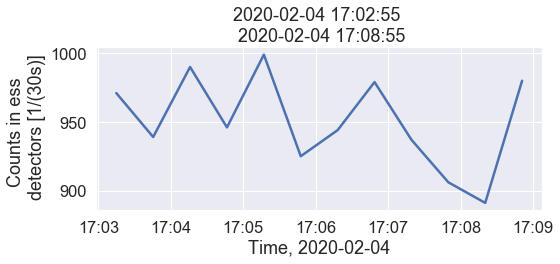

1162.00, 960.00, 64.78


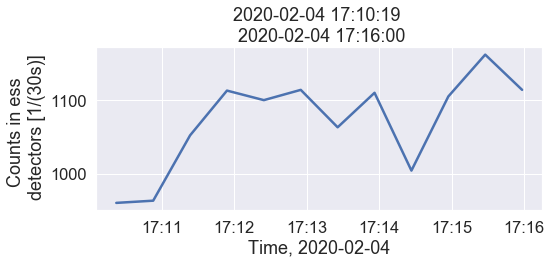

1100.00, 1014.00, 31.81


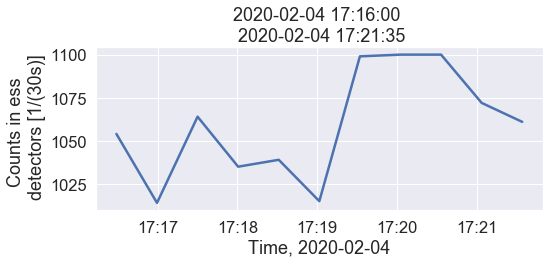

1453.00, 1270.00, 57.29


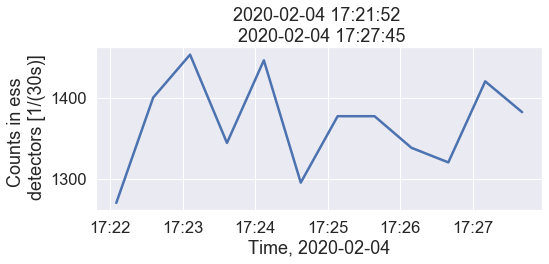

1191.00, 914.00, 75.29


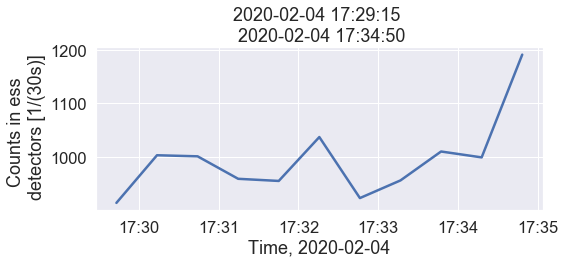

1499.00, 1257.00, 65.01


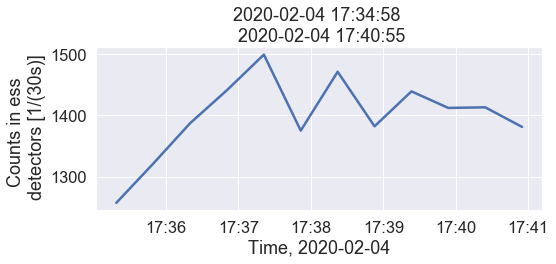

1372.00, 1150.00, 57.98


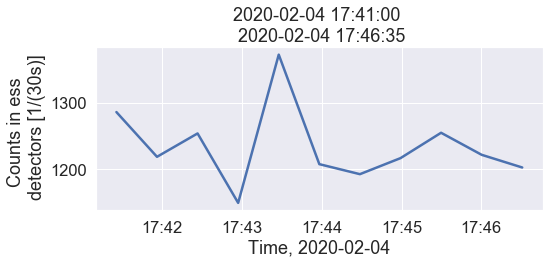

1334.00, 1156.00, 49.01


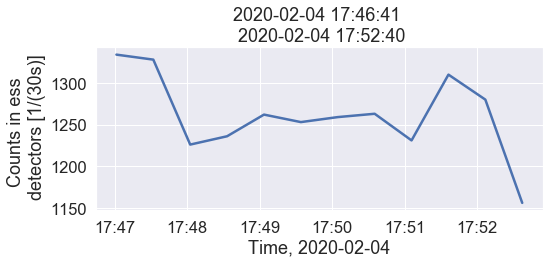

1422.00, 1129.00, 78.98


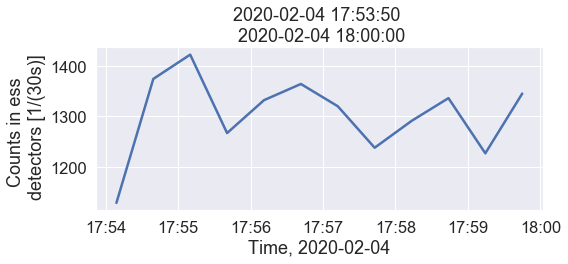

970.00, 870.00, 25.96


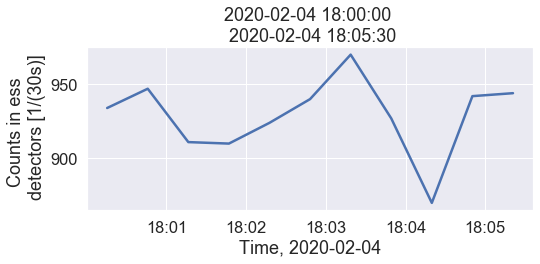

1135.00, 1039.00, 32.06


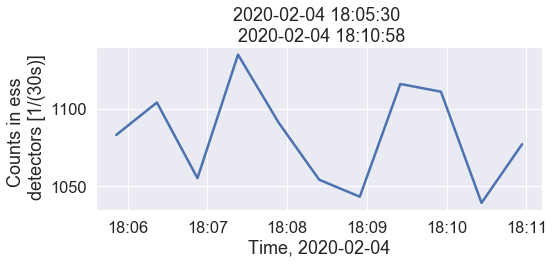

1473.00, 1281.00, 55.63


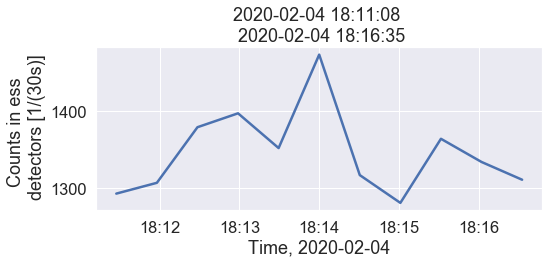

1409.00, 1322.00, 30.67


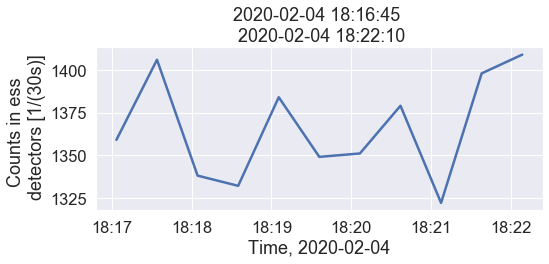

1008.00, 907.00, 37.03


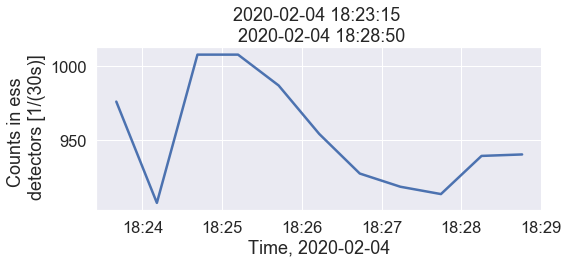

1020.00, 855.00, 42.87


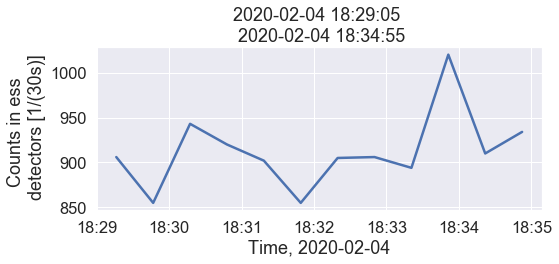

1187.00, 1037.00, 52.89


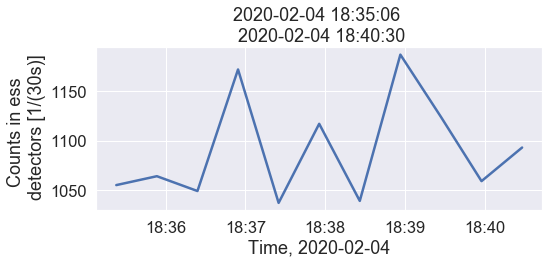

1421.00, 1273.00, 41.29


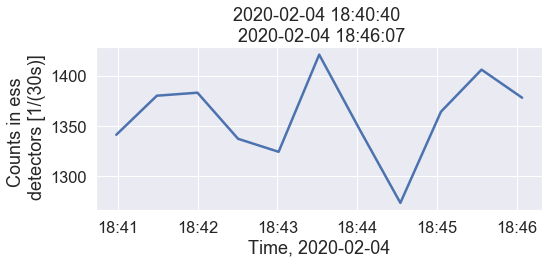

1227.00, 1180.00, 19.07


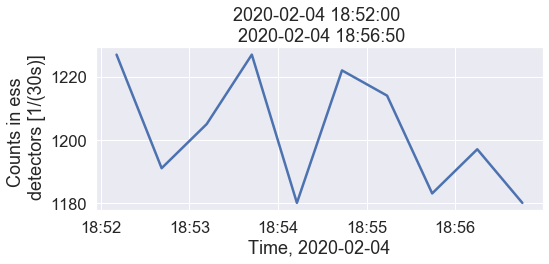

1461.00, 1250.00, 68.23


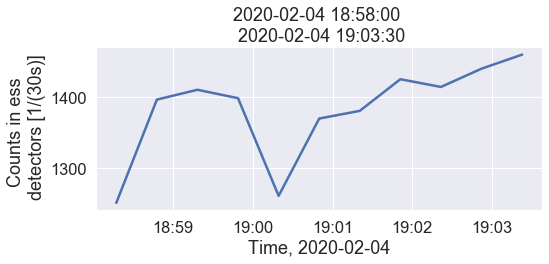

1462.00, 1321.00, 48.68


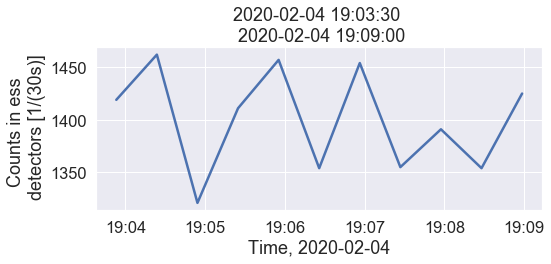

1065.00, 902.00, 42.36


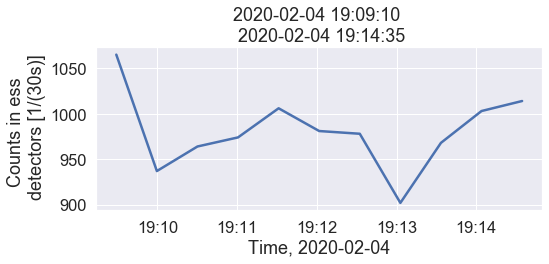

1471.00, 1356.00, 40.64


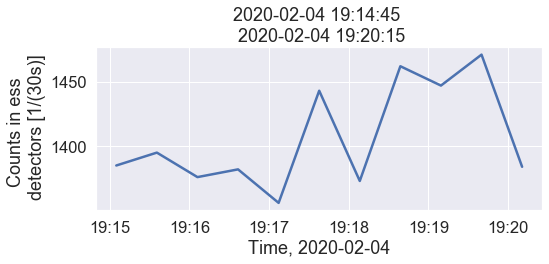

1254.00, 1074.00, 53.53


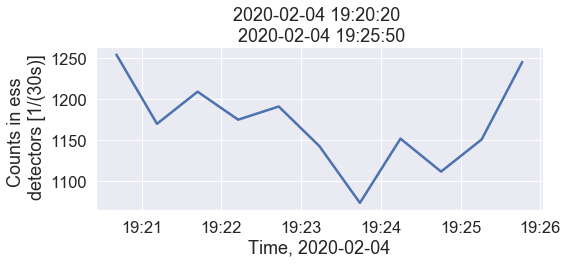

1051.00, 983.00, 22.54


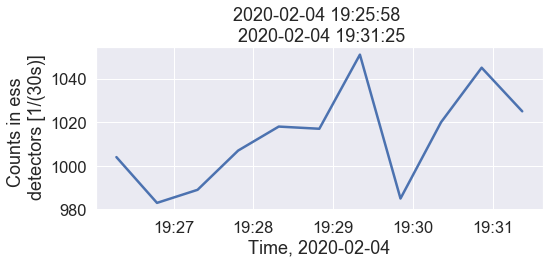

1272.00, 1067.00, 58.56


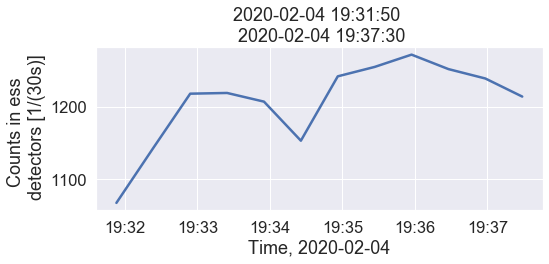

1581.00, 1475.00, 33.56


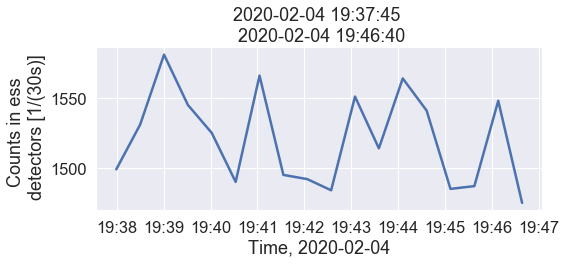

In [24]:
# remove first last time

# loop through edge position
ii = 0
for ii in range(0,data_pos.shape[0]):

    # get the beginning and end time, t0 and t1
    t0 = data_pos.iloc[ii, :].loc['time_start']
    t1 = data_pos.iloc[ii, :].loc['time_stop']
    pos = data_pos.iloc[ii, :].loc['edge_pos'] # mm
    ess_counts = data_ess[(data_ess.index > t0) & (data_ess.index < t1)].loc[:,'value']

    counts_max = ess_counts.max()
    counts_min = ess_counts.min()
    counts_std = ess_counts.std()
    
    if len(ess_counts)>0:

        print(f"{counts_max:.2f}, {counts_min:.2f}, {counts_std:.2f}")
        # check the counts in the ess detector, when not significantly change
        fig, ax = plt.subplots(figsize=(8,3))
        sns.set()
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
        sns.lineplot(x=ess_counts.index, y=ess_counts, ax=ax)
        ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        ax.set_ylabel('Counts in ess \n detectors [1/(30s)]')
        ax.set_xlabel(f'Time, {DAY}')
        plt.title(f"{t0} \n {t1}")
        plt.show()
    else:
        print(f"No data for ii {ii} t0 {t0} t1 {t1}")



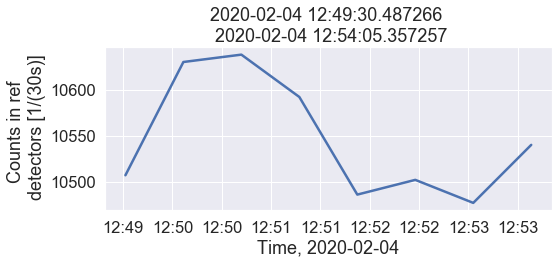

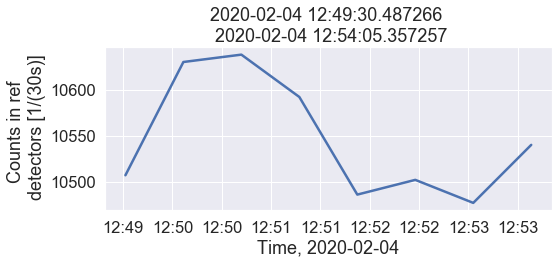

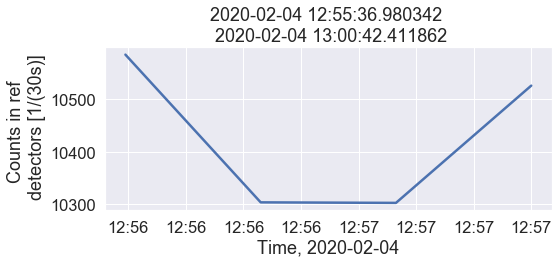

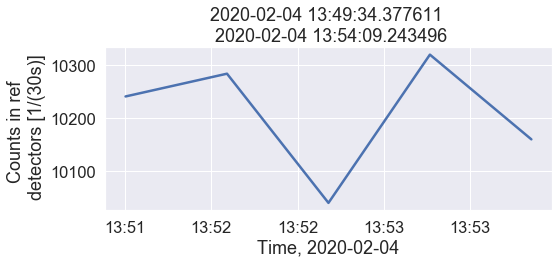

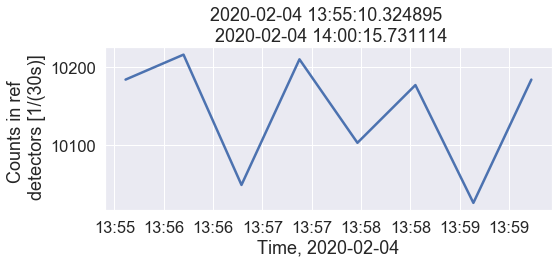

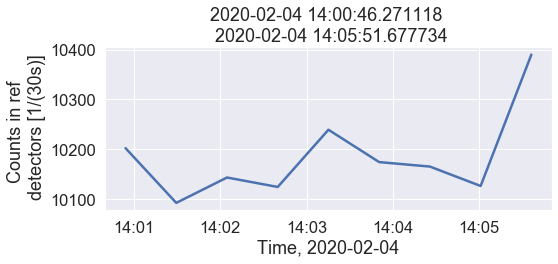

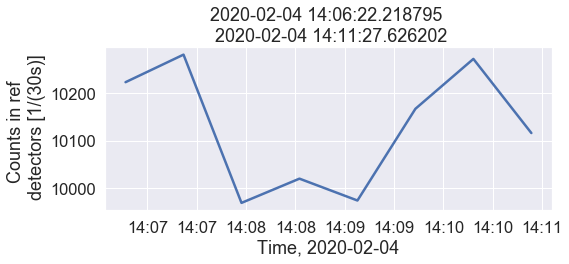

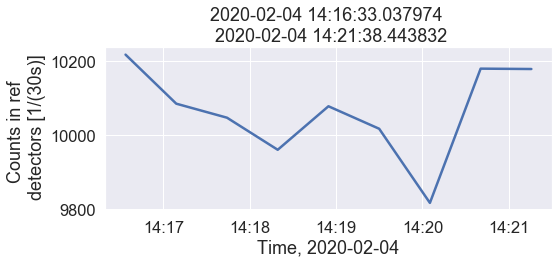

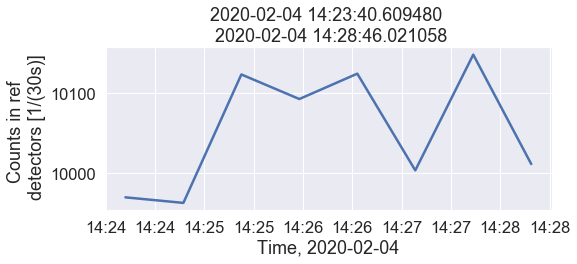

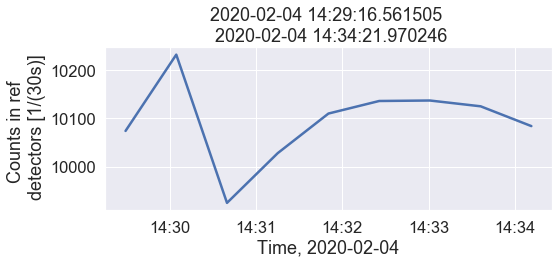

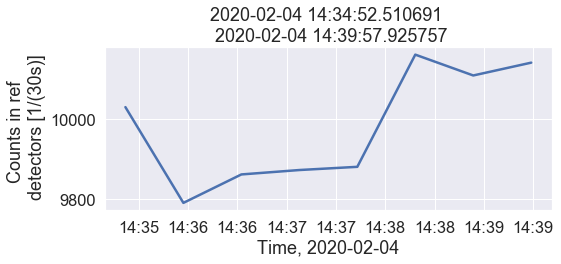

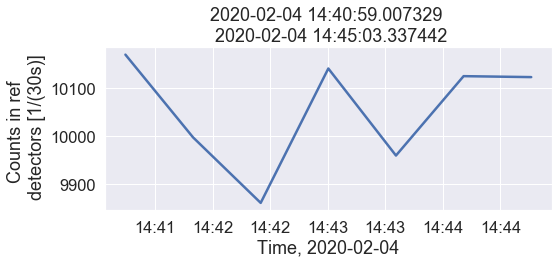

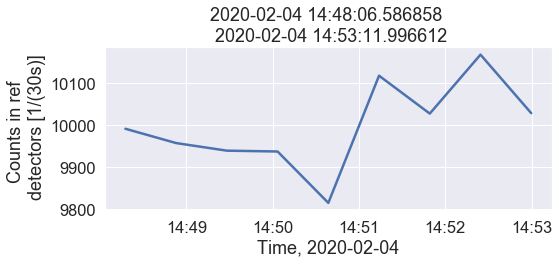

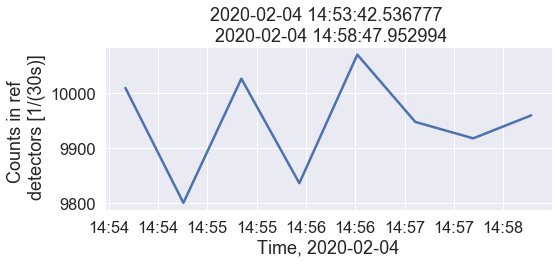

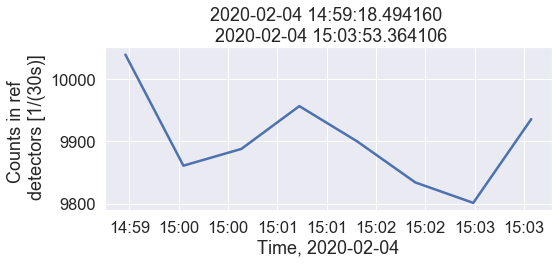

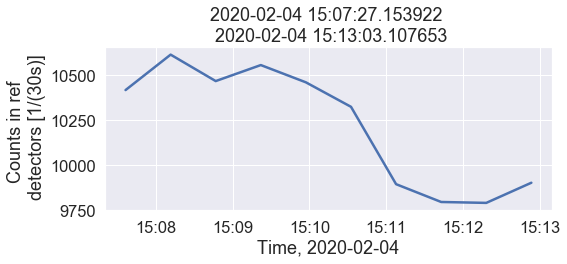

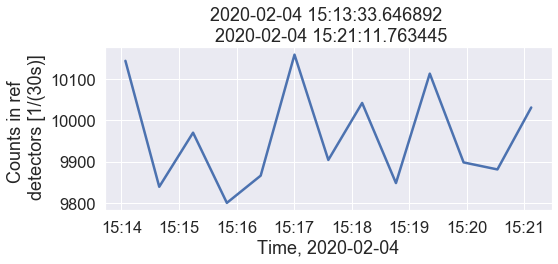

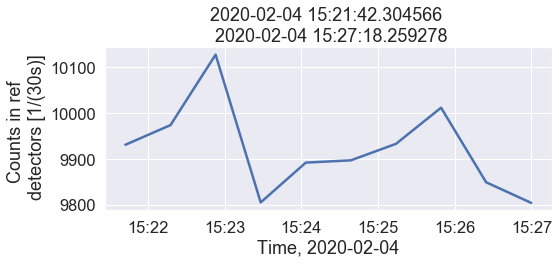

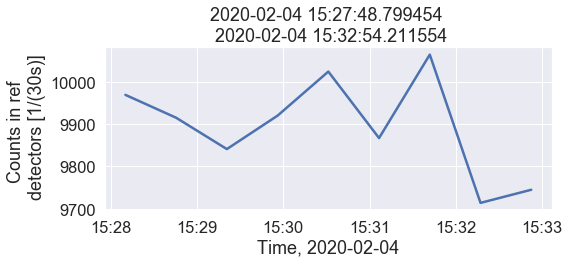

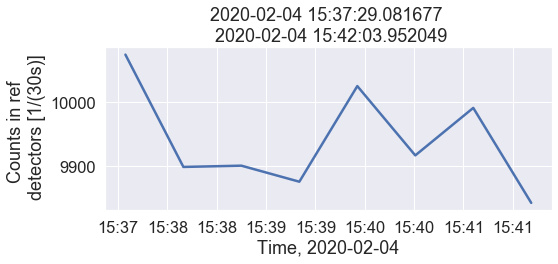

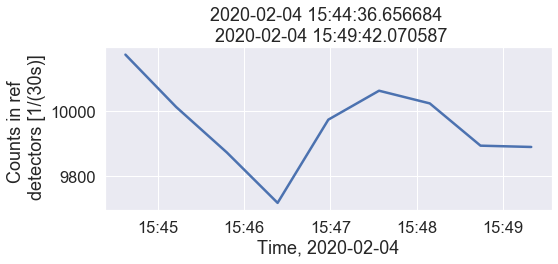

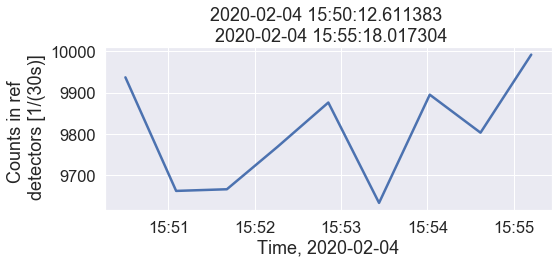

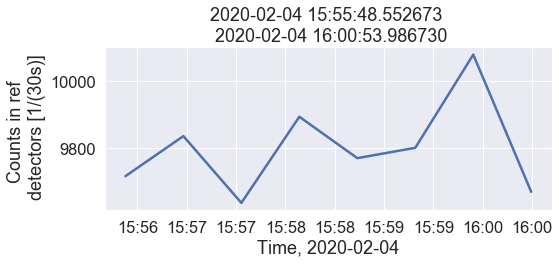

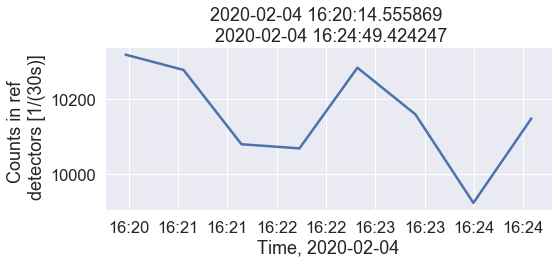

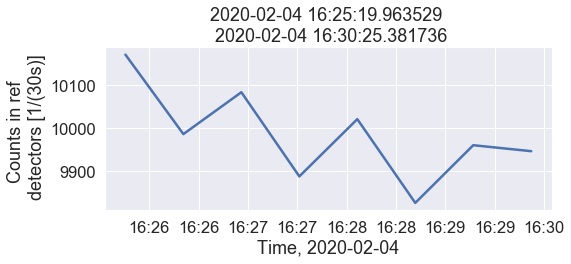

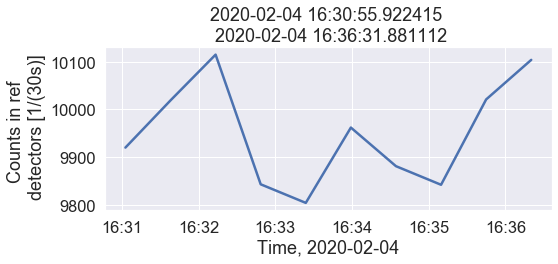

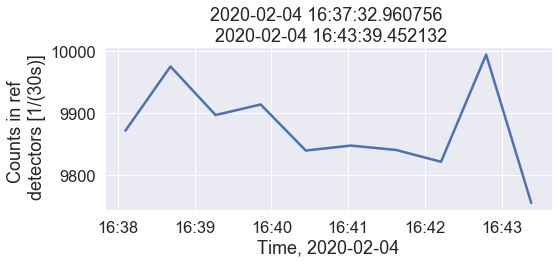

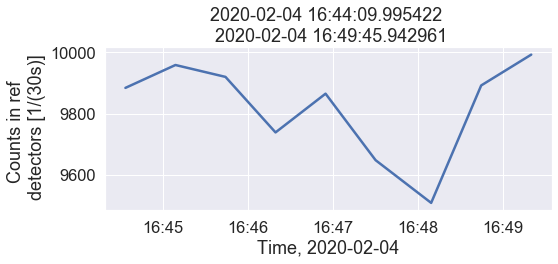

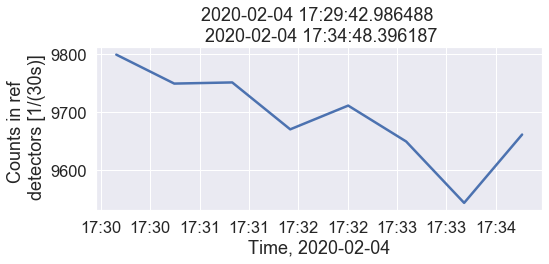

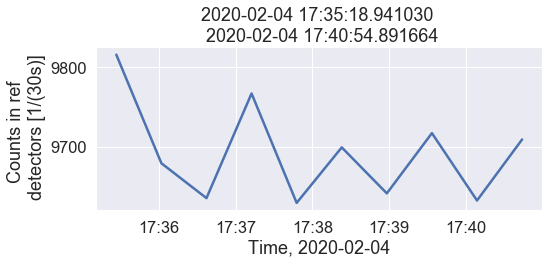

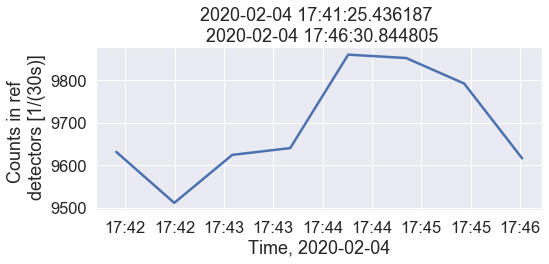

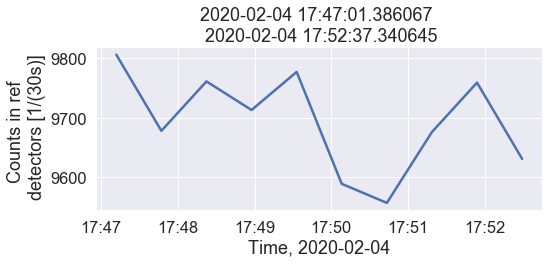

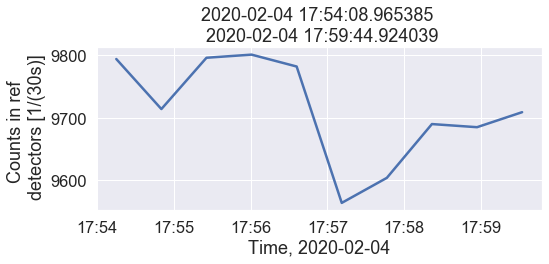

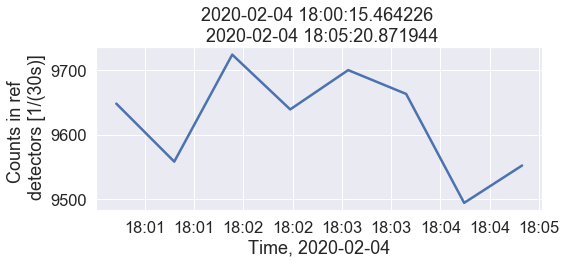

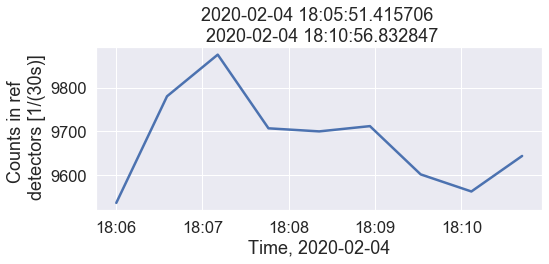

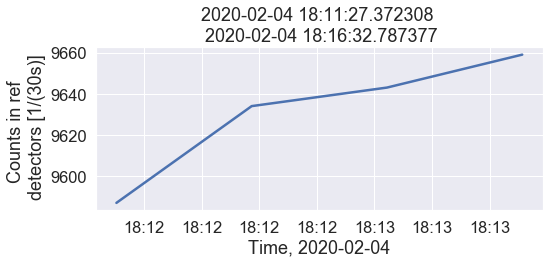

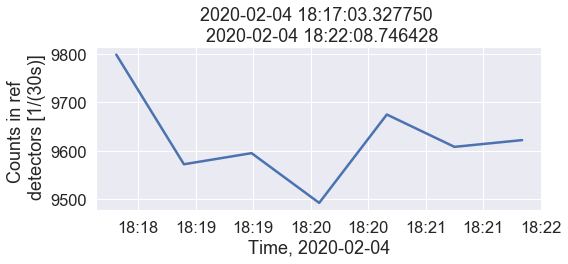

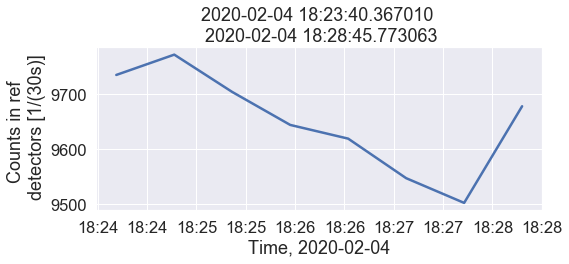

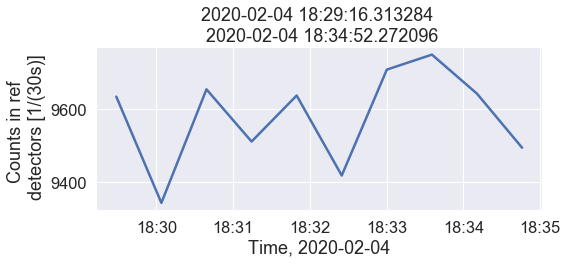

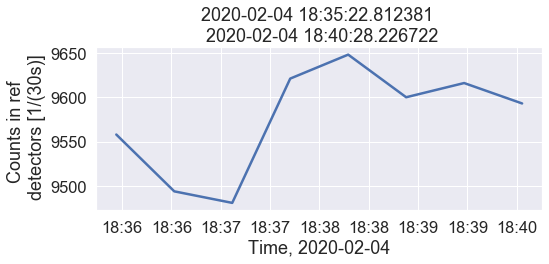

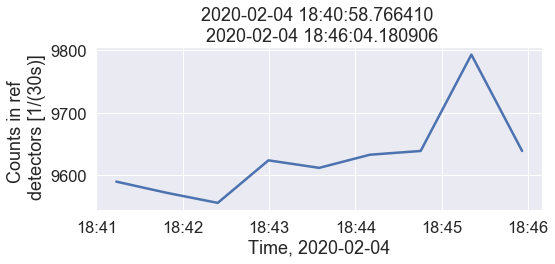

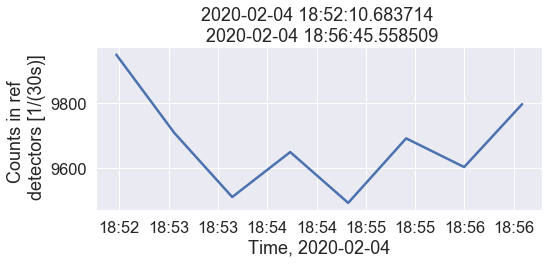

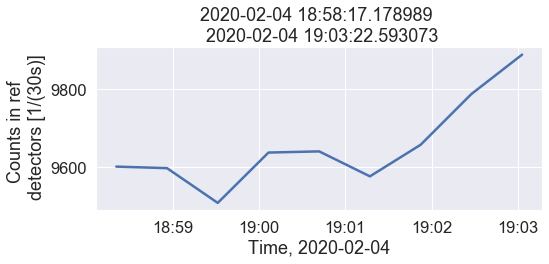

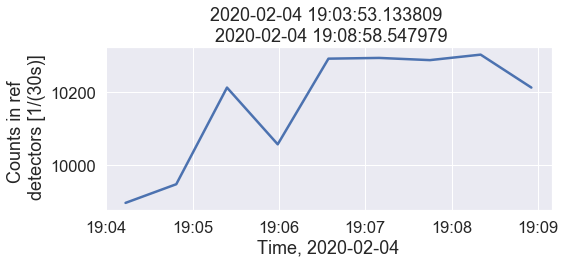

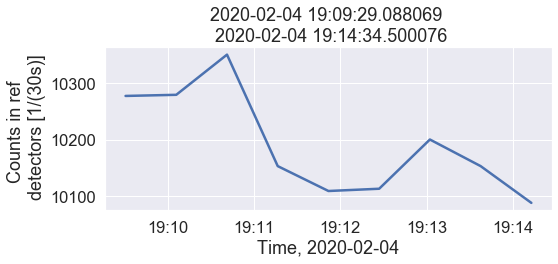

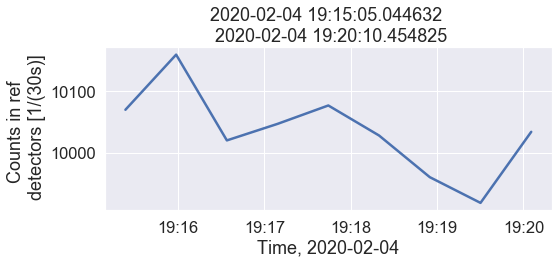

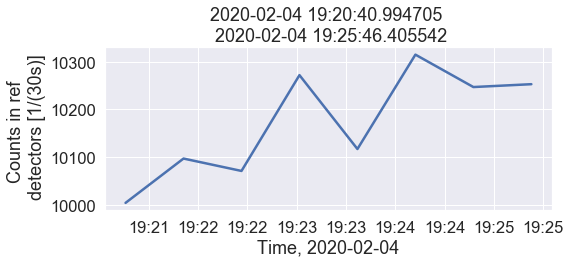

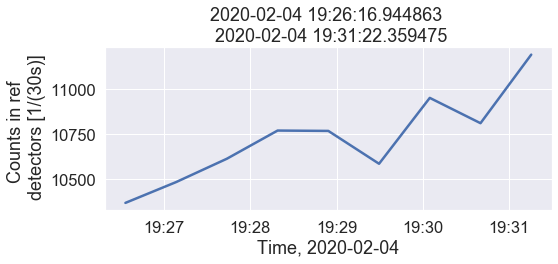

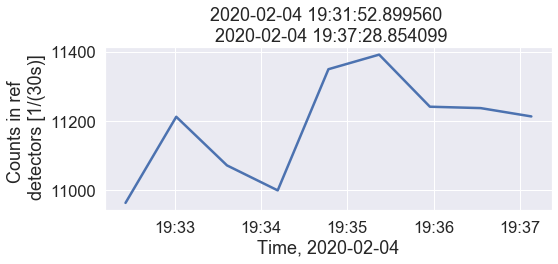

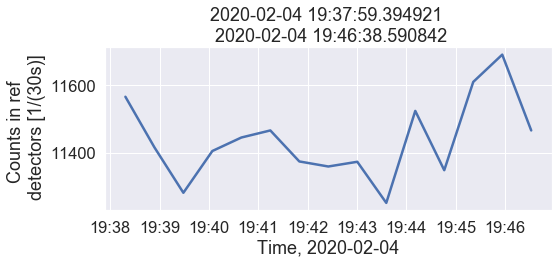

t0                         t1    pos  \
0  2020-02-04 12:49:30.487266 2020-02-04 12:54:05.357257  11.00   
1  2020-02-04 12:55:36.980342 2020-02-04 13:00:42.411862  23.00   
2  2020-02-04 13:01:12.951539 2020-02-04 13:07:19.443296  23.00   
3  2020-02-04 13:08:51.066808 2020-02-04 13:14:57.568323  12.00   
4  2020-02-04 13:15:28.109223 2020-02-04 13:21:34.609431  22.00   
5  2020-02-04 13:22:05.149151 2020-02-04 13:27:41.109770  13.00   
6  2020-02-04 13:36:50.855844 2020-02-04 13:41:56.261843  21.00   
7  2020-02-04 13:43:58.425935 2020-02-04 13:49:03.837146  14.00   
8  2020-02-04 13:49:34.377611 2020-02-04 13:54:09.243496  20.00   
9  2020-02-04 13:55:10.324895 2020-02-04 14:00:15.731114  15.00   
10 2020-02-04 14:00:46.271118 2020-02-04 14:05:51.677734  19.00   
11 2020-02-04 14:06:22.218795 2020-02-04 14:11:27.626202  16.00   
12 2020-02-04 14:16:33.037974 2020-02-04 14:21:38.443832  18.00   
13 2020-02-04 14:23:40.609480 2020-02-04 14:28:46.021058  17.00   
14 2020-02-04 14:29:16.561505 2020-02-04 14:34:21.970246  15.50   
15 2020-02-04 14:34:52.510691 2020-02-04 14:39:57.925757  18.50   
16 2020-02-04 14:40:59.007329 2020-02-04 14:45:03.337442  16.50   
17 2020-02-04 14:48:06.586858 2020-02-04 14:53:11.996612  17.50   
18 2020-02-04 14:53:42.536777 2020-02-04 14:58:47.952994  15.25   
19 2020-02-04 14:59:18.494160 2020-02-04 15:03:53.364106  18.25   
20 2020-02-04 15:07:27.153922 2020-02-04 15:13:03.107653  14.75   
21 2020-02-04 15:13:33.646892 2020-02-04 15:21:11.763445  14.00   
22 2020-02-04 15:21:42.304566 2020-02-04 15:27:18.259278   5.00   
23 2020-02-04 15:27:48.799454 2020-02-04 15:32:54.211554   0.00   
24 2020-02-04 15:37:29.081677 2020-02-04 15:42:03.952049  16.10   
25 2020-02-04 15:44:36.656684 2020-02-04 15:49:42.070587  17.90   
26 2020-02-04 15:50:12.611383 2020-02-04 15:55:18.017304  17.60   
27 2020-02-04 15:55:48.552673 2020-02-04 16:00:53.986730  16.90   
28 2020-02-04 16:20:14.555869 2020-02-04 16:24:49.424247  17.30   
29 2020-02-04 16:25:19.963529 2020-02-04 16:30:25.381736  18.40   
30 2020-02-04 16:30:55.922415 2020-02-04 16:36:31.881112  19.20   
31 2020-02-04 16:37:32.960756 2020-02-04 16:43:39.452132  17.00   
32 2020-02-04 16:44:09.995422 2020-02-04 16:49:45.942961  17.40   
33 2020-02-04 16:57:08.351413 2020-02-04 17:01:43.221785  19.30   
34 2020-02-04 17:03:14.846244 2020-02-04 17:08:50.800166  17.10   
35 2020-02-04 17:10:22.421625 2020-02-04 17:15:58.372272  17.80   
36 2020-02-04 17:16:28.912667 2020-02-04 17:21:34.326717  17.70   
37 2020-02-04 17:22:04.867024 2020-02-04 17:27:40.821806  18.70   
38 2020-02-04 17:29:42.986488 2020-02-04 17:34:48.396187  16.70   
39 2020-02-04 17:35:18.941030 2020-02-04 17:40:54.891664  18.90   
40 2020-02-04 17:41:25.436187 2020-02-04 17:46:30.844805  18.30   
41 2020-02-04 17:47:01.386067 2020-02-04 17:52:37.340645  18.50   
42 2020-02-04 17:54:08.965385 2020-02-04 17:59:44.924039  18.80   
43 2020-02-04 18:00:15.464226 2020-02-04 18:05:20.871944  16.30   
44 2020-02-04 18:05:51.415706 2020-02-04 18:10:56.832847  18.10   
45 2020-02-04 18:11:27.372308 2020-02-04 18:16:32.787377  19.50   
46 2020-02-04 18:17:03.327750 2020-02-04 18:22:08.746428  20.00   
47 2020-02-04 18:23:40.367010 2020-02-04 18:28:45.773063  17.85   
48 2020-02-04 18:29:16.313284 2020-02-04 18:34:52.272096  17.20   
49 2020-02-04 18:35:22.812381 2020-02-04 18:40:28.226722  18.20   
50 2020-02-04 18:40:58.766410 2020-02-04 18:46:04.180906  19.10   
51 2020-02-04 18:52:10.683714 2020-02-04 18:56:45.558509  18.35   
52 2020-02-04 18:58:17.178989 2020-02-04 19:03:22.593073  24.00   
53 2020-02-04 19:03:53.133809 2020-02-04 19:08:58.547979  19.00   
54 2020-02-04 19:09:29.088069 2020-02-04 19:14:34.500076  17.50   
55 2020-02-04 19:15:05.044632 2020-02-04 19:20:10.454825  19.70   
56 2020-02-04 19:20:40.994705 2020-02-04 19:25:46.405542  18.15   
57 2020-02-04 19:26:16.944863 2020-02-04 19:31:22.359475  16.50   
58 2020-02-04 19:31:52.899560 2020-02-04 19:37:28.854099  18.00   
59 2020

In [25]:
def get_total_counts(t0, t1, pos):
    # total counts counts in the ess detector

    data_ess_counts = pd.DataFrame(data_ess[(data_ess.index >= t0) & (data_ess.index <= t1)].loc[:,'value'])
    if len(data_ess_counts) > 0:

        # counting time in the ess in seconds
        ess_time = (data_ess_counts.index[-1]-data_ess_counts.index[0]).seconds
        ess_counts = data_ess_counts['value'].sum()
        # background counts during this time interval
        ess_bg_counts = counts_per_s_BG_agg * ess_time
        # background corrected counts
        ess_counts_bg_corr = ess_counts - ess_bg_counts
        # background corrected cps in ess
        ess_cps = ess_counts_bg_corr / ess_time
        
        t1 = data_ess_counts.index[-1]
        t0 = data_ess_counts.index[0]
        
        # reference detector counts in that interval
        ref_data = data_reference_s[(data_reference_s.index >= t0) & (data_reference_s.index <= t1)]
        if len(ref_data) > 0:
            ref_total_counts = ref_data.loc[:, 'sum_counts'].sum()
            # reference detector counting time
            ref_total_time = (ref_data.index[-1]-ref_data.index[0]).seconds
            # correct reference count using its background
            ref_bg_counts = ref_counts_per_s_BG_agg * ref_total_time
            # correct the reference counts with the background counts
            ref_counts_bg_corr = ref_total_counts - ref_bg_counts
            # background corrected cps in reference
            ref_cps = ref_counts_bg_corr / ref_total_time
            
            fig, ax = plt.subplots(figsize=(8,3))
            sns.set()
            sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
            sns.lineplot(x=ref_data.index, y=ref_data['sum_counts'], ax=ax)
            ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
            ax.set_ylabel('Counts in ref \n detectors [1/(30s)]')
            ax.set_xlabel(f'Time, {DAY}')
            plt.title(f"{t0} \n {t1}")
            plt.show()
        else:
            ref_cps = 1
            ref_total_counts = 1
            ref_total_time = 1
        
        # normalized ess cps (with reference counts)
        ess_cps_norm_ref = ess_cps / ref_cps
        
        # average dose
        avg_dose = data_dose[(data_dose.index >= t0) & (data_dose.index <= t1)].loc[:, 'dose_corrected'].mean()
        
        # counts normalized by average dose
        ess_cps_norm_dose = ess_cps / avg_dose
        s = pd.Series(
            [t0, t1, pos, ess_counts, ess_time,  
             ess_counts_bg_corr, ref_total_counts, ref_total_time, ess_cps, ref_cps, ess_cps_norm_ref, avg_dose, ess_cps_norm_dose], 
            index=['t0', 't1', 'pos', 'ess_total_counts', 'ess_total_time', 
                   'ess_counts_bg_corr', 'ref_total_counts', 'ref_total_time', 'ess_cps', 'ref_cps', 'ess_cps_norm_ref', 'avg_dose', 'ess_cps_norm_dose']
        )
        return s
    else:
        print(f"No data for t0 {t0}, t1 {t1}, pos {pos})")
        return None
# get total counts in the ess in that interval
# correct with the background (times measurement time)

# get dose in that time interval
# get reference counts in that time interval
data_result = data_pos.apply(lambda x: get_total_counts(x['time_start'], x['time_stop'], x['edge_pos']), axis=1)

data_result

## Predict the reference counts from the dose where missing

In [26]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='30S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('30S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    
    return df_out

In [27]:
t0 = data_dose_s.index[0]
t1 = data_dose_s.index[-1]
data_res_dose = resample_30_seconds(data_dose_s, ['dose_corrected'], t0, t1)
data_res_dose.index.name = 'time'


data_res_ref = resample_30_seconds(data_reference_s, ['sum_counts'], t0, t1)
data_res_ref.index.name = 'time'

data_res_dose = data_res_dose.loc[:"2020-02-04 19:49:00"]
data_res_ref = data_res_ref.loc[:"2020-02-04 19:49:00"]

for time in data_res_dose.index:
    if time not in data_res_ref.index:
        print(time)

for time in data_res_ref.index:
    if time not in data_res_dose.index:
        print(time)
        

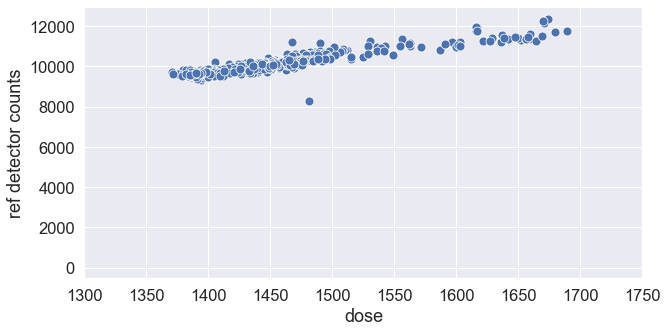

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=data_res_dose['dose_corrected'].values, y=data_res_ref['sum_counts'].values, ax=ax, s=80)

ax.set_ylabel('ref detector counts')
ax.set_xlabel(f'dose')
plt.xlim(1300, 1750)
plt.show()

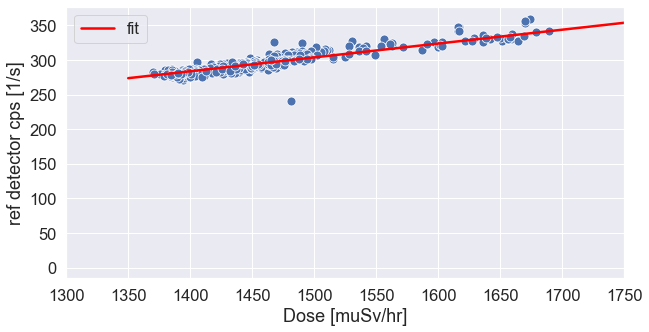

0.9752317167808159

In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# average readout time for reference detector
ref_readout_time = data_reference_full['ard_time'].value_counts().index[0]/1000

# remove nans from X and y
X = data_res_dose['dose_corrected'].values # select only between 1350 and 1750 muSv/h
y = data_res_ref['sum_counts'].values # select only between 8000 and 13000 counts

X_nan = np.isnan(X)
X = X[~X_nan] 
y = y[~X_nan] 

y_nan = np.isnan(y)
X = X[~y_nan] 
y = y[~y_nan] 

# convert y to cps instead of cp(30s)
y = y / ref_readout_time

X_train = X.reshape(-1,1)
y_train = y.reshape(-1,1)



reg = LinearRegression().fit(X_train, y_train)
# intercept
c = reg.intercept_[0]
# slope
m = reg.coef_[0]
X_fit = np.arange(1350,1750+1,1).reshape(-1,1)
y_fit = reg.predict(X_fit).reshape(-1)
X_fit = X_fit.reshape(-1)

fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=X, y=y, ax=ax, s=80)
sns.lineplot(x=X_fit, y=y_fit, ax=ax, color='red', label='fit')

ax.set_ylabel('ref detector cps [1/s]')
ax.set_xlabel(f'Dose [muSv/hr]')
plt.xlim(1300, 1750)
plt.show()
# coefficient of determination R^2 
reg.score(X_train, y_train)

In [30]:
reg.predict([[1550]]).reshape(-1)[0]

313.6682472282333

### Predict the total number of counts, use t0 and t1 as the time

In [31]:
# results subset without reference detector data
data_wo_ref = data_result[data_result['ref_total_counts'] == 1]

def predict_ref_counts(row, reg):
    """ 
    Predicts the reference counts based on the regressor reg and a row.
    """
    t0 = row['t0']
    t1 = row['t1'] 
    # to predict the total number of counts, approximate by the seconds that the ess detector was counting
    t_diff = (t1-t0).seconds
    # average dose in muSv/hr
    avg_dose = row['avg_dose']
    
    # predicted cps in reference detector
    pred_ref_cps = reg.predict([[avg_dose]]).reshape(-1)[0]
    
    # predicted cps in reference detector background correction
    pred_ref_cps_total = pred_ref_cps - ref_counts_per_s_BG_agg 
    
    return pd.Series(
                        [t_diff, pred_ref_cps, pred_ref_cps_total],
        index=["pred_ref_time", "pred_ref_cps", "pred_ref_cps_total"]
                    )

a = data_result.apply(lambda x: predict_ref_counts(x, reg), axis=1)
data_result_pred = data_result.merge(a, on=data_result.index).drop('key_0', axis=1)
data_result_pred.head()

t0                         t1   pos  \
0 2020-02-04 12:49:30.487266 2020-02-04 12:54:05.357257  11.0   
1 2020-02-04 12:55:36.980342 2020-02-04 13:00:42.411862  23.0   
2 2020-02-04 13:01:12.951539 2020-02-04 13:07:19.443296  23.0   
3 2020-02-04 13:08:51.066808 2020-02-04 13:14:57.568323  12.0   
4 2020-02-04 13:15:28.109223 2020-02-04 13:21:34.609431  22.0   

   ess_total_counts  ess_total_time  ess_counts_bg_corr  ref_total_counts  \
0              8814             274         8790.070154           84372.0   
1             15757             305        15730.362762           41718.0   
2             18825             366        18793.035315               1.0   
3             11465             366        11433.035315               1.0   
4             18189             366        18157.035315               1.0   

   ref_total_time    ess_cps     ref_cps  ess_cps_norm_ref     avg_dose  \
0             246  32.080548  340.419382          0.094238  1477.766898   
1             105  51.574960  394.758058          0.130650  1472.397829   
2               1  51.347091    1.000000         51.347091  1473.988137   
3               1  31.237801    1.000000         31.237801  1473.570274   
4               1  49.609386    1.000000         49.609386  1470.107534   

   ess_cps_norm_dose  pred_ref_time  pred_ref_cps  pred_ref_cps_total  
0           0.021709          274.0    299.215469          296.659242  
1           0.035028          305.0    298.141198          295.584971  
2           0.034835          366.0    298.459395          295.903168  
3           0.021199          366.0    298.375787          295.819559  
4           0.033745          366.0    297.682944          295.126716

## Visualize the ess

In [32]:
# normalize by the max 
edge_fully_out = data_result[data_result['pos'] == 24].loc[:,'ess_cps_norm_ref'].values.mean()
data_result['ess_cps_norm_ref_scaled'] = data_result['ess_cps_norm_ref']/edge_fully_out

edge_fully_out = data_result[data_result['pos'] == 24].loc[:,'ess_cps_norm_dose'].values.mean()
data_result['ess_cps_norm_dose_scaled'] = data_result['ess_cps_norm_dose']/edge_fully_out


In [33]:
# predicted ref used for the normalization
data_result_pred['ess_cps_norm_ref_pred'] = data_result_pred['ess_cps'] / data_result_pred['pred_ref_cps_total']
# normalize by the max 
edge_fully_out = data_result_pred[data_result_pred['pos'] == 24].loc[:,'ess_cps_norm_ref_pred'].values.mean()
data_result_pred['ess_cps_norm_ref_pred_scaled'] = data_result_pred['ess_cps_norm_ref_pred']/edge_fully_out

### Use ONLY the predicted cps in the reference detectors

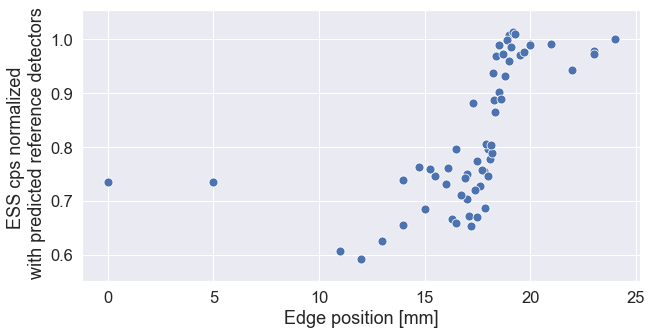

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x='pos', y='ess_cps_norm_ref_pred_scaled', data=data_result_pred, ax=ax, s=80)

ax.set_ylabel('ESS cps normalized \n with predicted reference detectors')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

### Use the predictions only where no reference detector data was available

In [35]:
data_result_pred.head()

t0                         t1   pos  \
0 2020-02-04 12:49:30.487266 2020-02-04 12:54:05.357257  11.0   
1 2020-02-04 12:55:36.980342 2020-02-04 13:00:42.411862  23.0   
2 2020-02-04 13:01:12.951539 2020-02-04 13:07:19.443296  23.0   
3 2020-02-04 13:08:51.066808 2020-02-04 13:14:57.568323  12.0   
4 2020-02-04 13:15:28.109223 2020-02-04 13:21:34.609431  22.0   

   ess_total_counts  ess_total_time  ess_counts_bg_corr  ref_total_counts  \
0              8814             274         8790.070154           84372.0   
1             15757             305        15730.362762           41718.0   
2             18825             366        18793.035315               1.0   
3             11465             366        11433.035315               1.0   
4             18189             366        18157.035315               1.0   

   ref_total_time    ess_cps     ref_cps  ess_cps_norm_ref     avg_dose  \
0             246  32.080548  340.419382          0.094238  1477.766898   
1             105  51.574960  394.758058          0.130650  1472.397829   
2               1  51.347091    1.000000         51.347091  1473.988137   
3               1  31.237801    1.000000         31.237801  1473.570274   
4               1  49.609386    1.000000         49.609386  1470.107534   

   ess_cps_norm_dose  pred_ref_time  pred_ref_cps  pred_ref_cps_total  \
0           0.021709          274.0    299.215469          296.659242   
1           0.035028          305.0    298.141198          295.584971   
2           0.034835          366.0    298.459395          295.903168   
3           0.021199          366.0    298.375787          295.819559   
4           0.033745          366.0    297.682944          295.126716   

   ess_cps_norm_ref_pred  ess_cps_norm_ref_pred_scaled  
0               0.108139                      0.606855  
1               0.174484                      0.979169  
2               0.173527                      0.973795  
3               0.105597                      0.592591  
4               0.168095                      0.943315

In [36]:
data_result_pred['ref_cps_pred'] = data_result_pred['ref_cps']
data_result_pred.loc[data_result_pred['ref_cps_pred'] == 1, 'ref_cps_pred'] = data_result_pred.loc[data_result_pred['ref_cps_pred'] == 1, 'pred_ref_cps_total']

In [37]:
# predicted ref used for the normalization, only where the ref was missing
data_result_pred['ess_cps_norm_ref_pred_hybrid'] = data_result_pred['ess_cps'] / data_result_pred['ref_cps_pred']
# normalize by the max 
edge_fully_out = data_result_pred[data_result_pred['pos'] == 24].loc[:,'ess_cps_norm_ref_pred_hybrid'].values.mean()
data_result_pred['ess_cps_norm_ref_pred_hybrid_scaled'] = data_result_pred['ess_cps_norm_ref_pred_hybrid']/edge_fully_out
data_result_pred.head()

t0                         t1   pos  \
0 2020-02-04 12:49:30.487266 2020-02-04 12:54:05.357257  11.0   
1 2020-02-04 12:55:36.980342 2020-02-04 13:00:42.411862  23.0   
2 2020-02-04 13:01:12.951539 2020-02-04 13:07:19.443296  23.0   
3 2020-02-04 13:08:51.066808 2020-02-04 13:14:57.568323  12.0   
4 2020-02-04 13:15:28.109223 2020-02-04 13:21:34.609431  22.0   

   ess_total_counts  ess_total_time  ess_counts_bg_corr  ref_total_counts  \
0              8814             274         8790.070154           84372.0   
1             15757             305        15730.362762           41718.0   
2             18825             366        18793.035315               1.0   
3             11465             366        11433.035315               1.0   
4             18189             366        18157.035315               1.0   

   ref_total_time    ess_cps     ref_cps  ...     avg_dose  ess_cps_norm_dose  \
0             246  32.080548  340.419382  ...  1477.766898           0.021709   
1             105  51.574960  394.758058  ...  1472.397829           0.035028   
2               1  51.347091    1.000000  ...  1473.988137           0.034835   
3               1  31.237801    1.000000  ...  1473.570274           0.021199   
4               1  49.609386    1.000000  ...  1470.107534           0.033745   

   pred_ref_time  pred_ref_cps  pred_ref_cps_total  ess_cps_norm_ref_pred  \
0          274.0    299.215469          296.659242               0.108139   
1          305.0    298.141198          295.584971               0.174484   
2          366.0    298.459395          295.903168               0.173527   
3          366.0    298.375787          295.819559               0.105597   
4          366.0    297.682944          295.126716               0.168095   

   ess_cps_norm_ref_pred_scaled  ref_cps_pred  ess_cps_norm_ref_pred_hybrid  \
0                      0.606855    340.419382                      0.094238   
1                      0.979169    394.758058                      0.130650   
2                      0.973795    295.903168                      0.173527   
3                      0.592591    295.819559                      0.105597   
4                      0.943315    295.126716                      0.168095   

   ess_cps_norm_ref_pred_hybrid_scaled  
0                             0.578414  
1                             0.801898  
2                             1.065068  
3                             0.648134  
4                             1.031731  

[5 rows x 21 columns]

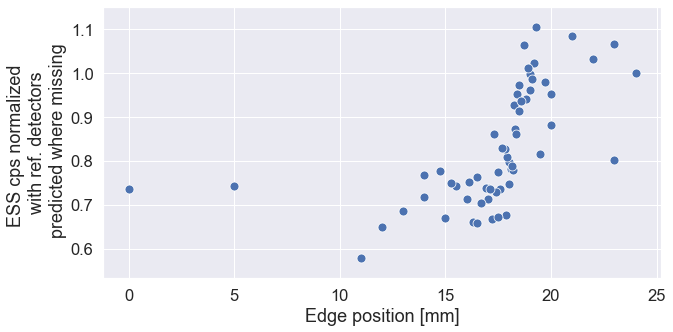

In [38]:

fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x='pos', y='ess_cps_norm_ref_pred_hybrid_scaled', data=data_result_pred, ax=ax, s=80)

ax.set_ylabel('ESS cps normalized \n with ref. detectors \n predicted where missing')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

In [39]:
# ess_cps_norm_ref_scaled
data_result_pred_t = data_result_pred
data_result_pred_t = data_result_pred_t[data_result_pred_t['ess_cps_norm_ref_scaled'] < 10]
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x='pos', y='ess_cps_norm_ref_scaled', data=data_result_pred_t, ax=ax, s=80)

ax.set_ylabel('ESS cps normalized \n with ref. detectors ')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

KeyError: 'ess_cps_norm_ref_scaled'

## Use the average dose to normalize

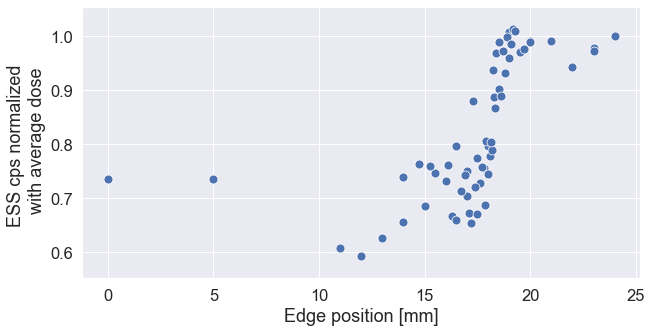

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x='pos', y='ess_cps_norm_dose_scaled', data=data_result, ax=ax, s=80)

ax.set_ylabel('ESS cps normalized \n with average dose')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

# Continue with reference detector normed and fit ESF

In [41]:
def get_edge_center(dataframe, metric, thresh_out, thresh_in):
    """
    dataframe: results dataframe,
   metric metric by which to chose the centering (earlier analysis)
    thresh_out: x positions when the edge was out
    thresh_in: x positions when the edge was fully in
    """
#     thresh_out = 21  # edge completely removed
#     thresh_in = 15.5  # edge completely in

    mu_out = np.mean(dataframe[metric][ dataframe.pos > thresh_out ])
    mu_in = np.mean(dataframe[metric][ dataframe.pos < thresh_in ])
    print(f'Mean of counts when edge is out: {mu_out}')
    print(f'Mean of counts when edge is in: {mu_in}')
    

    mu_out = np.mean(dataframe[metric][ dataframe.pos > thresh_out ])
    mu_in = np.mean(dataframe[metric][ dataframe.pos < thresh_in ])
    print(f'Mean of counts when edge is out: {mu_out}')
    print(f'Mean of counts when edge is in: {mu_in}')

    # linear fit around the middle region
    center_estimated = 18.5  # edge pos center estimated in mm
    pts_fit = 1  # mm left and right of center to take for fit
    x_fit_range1 = center_estimated + pts_fit
    x_fit_range2 = center_estimated - pts_fit
    def fitfunc(p, x):
        return p[0] * x + p[1]
    def errfunc(p, x, y):
        return fitfunc(p, x) - y # Distance to the fit function

    p0 = [1, 1] # Initial guess for the parameters
    X_f = dataframe.pos[ (dataframe.pos <= x_fit_range1) & (dataframe.pos >= x_fit_range2) ].values
    Y_f = dataframe[metric][ (dataframe.pos <= x_fit_range1) & (dataframe.pos >= x_fit_range2) ].values

    p1, success = optimize.leastsq(errfunc, p0[:], args=(X_f, Y_f))
    X_fit = np.arange(15.5,21+0.01,0.01)
    Y_fit = fitfunc(p1,X_fit)

    # this code plots the centering
    fig, ax = plt.subplots(figsize=(10,5))
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    plt.scatter(dataframe.pos, dataframe[metric])
    plt.plot([dataframe.pos.min(), dataframe.pos.max()], [mu_in, mu_in], c='red', label='mu edge in or out')
    plt.plot([dataframe.pos.min(), dataframe.pos.max()], [mu_out, mu_out], c='red')

    plt.plot(X_fit, Y_fit, c='green', label='linear fit')
    plt.xlabel('Edge position [mm]')
    plt.ylabel('ESS cps normalized \n with ref detectors')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()



    # find where the linear fit intersects the mean curved (edge fully in or fully out curve)
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    near_mu = np.array([])  # first entry: edge fully in, second entry: edge fully out in mm edge position
    for mu in [mu_in, mu_out]:
        idx = find_nearest(Y_fit, mu)
        near_mu = np.append(near_mu,X_fit[idx])

    # center is in between the two
    center = np.mean(near_mu)
    print(near_mu)
    print(f"Center point (symmetry) is {center} mm.")
    
    return center

#### Center for the hybrid approach (reference detectors and where not available predicted from dose)

Mean of counts when edge is out: 0.9967674059894751
Mean of counts when edge is in: 0.7071335089660639
Mean of counts when edge is out: 0.9967674059894751
Mean of counts when edge is in: 0.7071335089660639


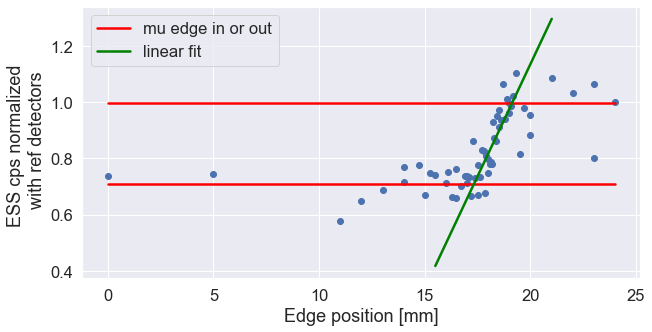

[17.32 19.13]
Center point (symmetry) is 18.224999999999945 mm.


In [54]:
thresh_out = 20
thresh_in = 15.5
metric = 'ess_cps_norm_ref_pred_hybrid_scaled'
center = get_edge_center(data_result_pred, metric, thresh_out, thresh_in)
data_result_pred['pos_centered_hybrid'] = data_result['pos'] - center


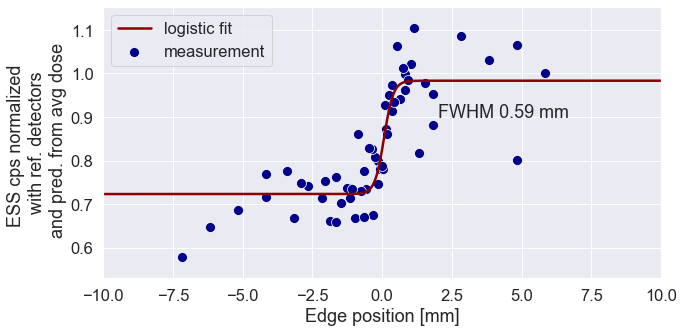

In [43]:
m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
x = data_result_pred['pos_centered_hybrid'].values
x = x[~np.isnan(x)]
y = data_result_pred['ess_cps_norm_ref_pred_hybrid_scaled'].values
y = y[~np.isnan(y)]
def fitfunc(x, *p):
    a, b, c, d = p
    z = np.exp( -( (x-b)/(c) ) )
    # z = np.exp( -( (x-p[1])/(p[2]) ) )
    return (a / ( 1 + z )) + d
    # return (p[0] / ( 1 + z )) + p[3]

p0 = [0.5,0.5,0.5,0.5]
popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
# print(popt)
FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
# print(FWHM)
X = np.arange(-10, 10+0.01, 0.01)
Y_fit = fitfunc(X, *popt)
    
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=data_result_pred['pos_centered_hybrid'], y=data_result_pred['ess_cps_norm_ref_pred_hybrid_scaled'], color='darkblue', ax=ax, s=100, label='measurement')
sns.lineplot(x=X,y=Y_fit, color='darkred', ax=ax, label='logistic fit')
ax.set_ylabel('ESS cps normalized \n with ref. detectors \n and pred. from avg dose')
ax.set_xlabel(f'Edge position [mm]')
plt.text(2, 0.9, f'FWHM {FWHM:.2f} mm')
# ax.set_xticks(np.arange(-7.5,7.5+2,2))
plt.xlim(-10,10)
plt.show()

In [44]:
l_SS_tot = lambda x: ((x-np.mean(x))**2).sum() # total sum of squares
l_SS_res = lambda y_pred, y_true: ((y_pred-np.mean(y_true))**2).sum() # residual sum of squares
l_R2 = lambda SS_tot, SS_res: 1 - (SS_res/SS_tot) # coefficient of determination

y_true = y
y_pred = fitfunc(x, *popt)

SS_tot = l_SS_tot(y_true) # observed data
SS_res = l_SS_res(y_pred, y_true)

R2 = l_R2(SS_tot, SS_res)
SS_tot, SS_res, R2

(1.0232103314641086, 0.7859188499435095, 0.23190880137132652)

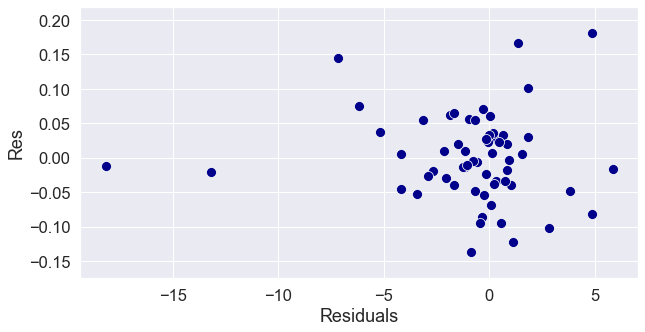

In [46]:
chisq = np.sum((y_true - y_pred)**2)/(np.std(y_true))**2
chisq/(len(y_pred)-4)
residuals = (y_pred - y_true)
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=x,y=residuals, color='darkblue', ax=ax, s=100)
ax.set_ylabel('Res')
ax.set_xlabel(f'Residuals')
plt.show()

#### Center for the dose approach

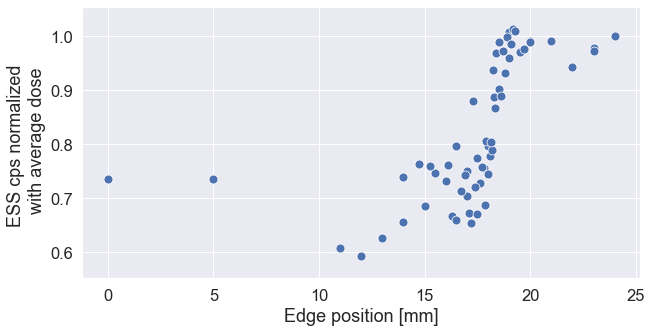

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x='pos', y='ess_cps_norm_dose_scaled', data=data_result, ax=ax, s=80)

ax.set_ylabel('ESS cps normalized \n with average dose')
ax.set_xlabel(f'Edge position [mm]')

plt.show()

Mean of counts when edge is out: 0.9739304266512294
Mean of counts when edge is in: 0.6899690000372655
Mean of counts when edge is out: 0.9739304266512294
Mean of counts when edge is in: 0.6899690000372655


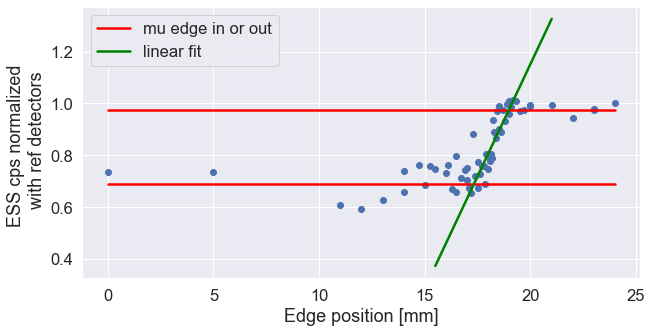

[17.34 18.98]
Center point (symmetry) is 18.159999999999943 mm.


In [59]:
thresh_out = 21
thresh_in = 15.5
metric = 'ess_cps_norm_dose_scaled'
center = get_edge_center(data_result, metric, thresh_out, thresh_in)
data_result['pos_centered_dose'] = data_result['pos'] - center


In [74]:
# filter 0 and 5
# data_result_t = data_result[(data_result['pos_centered_dose'] > -4) & (data_result['pos_centered_dose'] < 3.2)]
data_result_t = data_result

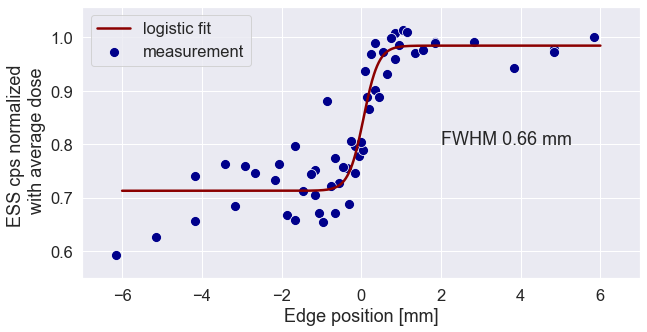

In [75]:
m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
x = data_result_t['pos_centered_dose'].values
x = x[~np.isnan(x)]
y = data_result_t['ess_cps_norm_dose_scaled'].values
y = y[~np.isnan(y)]


def fitfunc(x, *p):
    a, b, c, d = p
    z = np.exp( -( (x-b)/(c) ) )
    # z = np.exp( -( (x-p[1])/(p[2]) ) )
    return (a / ( 1 + z )) + d
    # return (p[0] / ( 1 + z )) + p[3]

p0 = [1,1,1,1]
popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
# print(popt)
FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
# print(FWHM)
X = np.arange(-6, 6+0.01, 0.01)
Y_fit = fitfunc(X, *popt)
    
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=data_result_t['pos_centered_dose'], y=data_result_t['ess_cps_norm_dose_scaled'], color='darkblue', ax=ax, s=100, label='measurement')
sns.lineplot(x=X,y=Y_fit, color='darkred', ax=ax, label='logistic fit')
ax.set_ylabel('ESS cps normalized \n with average dose')
ax.set_xlabel(f'Edge position [mm]')
plt.text(2, 0.8, f'FWHM {FWHM:.2f} mm')
# ax.set_xticks(np.arange(-7.5,7.5+2,2))
plt.xlim(-7,7)
plt.show()

# Normalized only with raw reference detector readings

In [78]:
data_result.head()

t0                         t1   pos  \
0 2020-02-04 12:49:30.487266 2020-02-04 12:54:05.357257  11.0   
1 2020-02-04 12:55:36.980342 2020-02-04 13:00:42.411862  23.0   
2 2020-02-04 13:01:12.951539 2020-02-04 13:07:19.443296  23.0   
3 2020-02-04 13:08:51.066808 2020-02-04 13:14:57.568323  12.0   
4 2020-02-04 13:15:28.109223 2020-02-04 13:21:34.609431  22.0   

   ess_total_counts  ess_total_time  ess_counts_bg_corr  ref_total_counts  \
0              8814             274         8790.070154           84372.0   
1             15757             305        15730.362762           41718.0   
2             18825             366        18793.035315               1.0   
3             11465             366        11433.035315               1.0   
4             18189             366        18157.035315               1.0   

   ref_total_time    ess_cps     ref_cps  ess_cps_norm_ref     avg_dose  \
0             246  32.080548  340.419382          0.094238  1477.766898   
1             105  51.574960  394.758058          0.130650  1472.397829   
2               1  51.347091    1.000000         51.347091  1473.988137   
3               1  31.237801    1.000000         31.237801  1473.570274   
4               1  49.609386    1.000000         49.609386  1470.107534   

   ess_cps_norm_dose  ess_cps_norm_ref_scaled  ess_cps_norm_dose_scaled  \
0           0.021709                 0.578414                  0.606731   
1           0.035028                 0.801898                  0.978981   
2           0.034835               315.156902                  0.973604   
3           0.021199               191.730603                  0.592475   
4           0.033745               304.491260                  0.943138   

   pos_centered_dose  
0              -7.16  
1               4.84  
2               4.84  
3              -6.16  
4               3.84

In [88]:
# data_result_t0 = data_result[data_result['ess_cps_norm_ref_scaled'] < 150]
data_result_t0 = data_result
data_result[data_result['ess_cps_norm_ref_scaled'] < 150].shape, data_result[data_result['ess_cps_norm_ref_scaled'] > 150].shape

((49, 16), (11, 16))

<ipython-input-86-9bef1a68d585>:10: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-b)/(c) ) )
/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


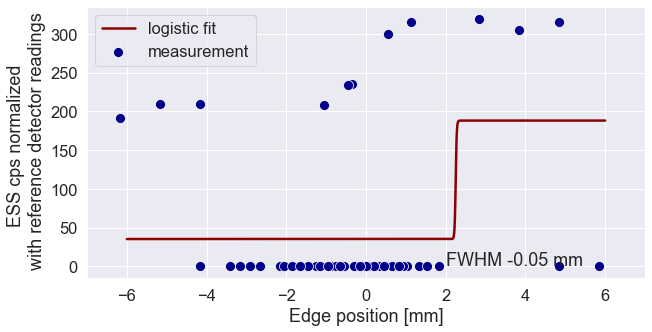

In [86]:
m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
x = data_result_t0['pos_centered_dose'].values
x = x[~np.isnan(x)]
y = data_result_t0['ess_cps_norm_ref_scaled'].values
y = y[~np.isnan(y)]


def fitfunc(x, *p):
    a, b, c, d = p
    z = np.exp( -( (x-b)/(c) ) )
    # z = np.exp( -( (x-p[1])/(p[2]) ) )
    return (a / ( 1 + z )) + d
    # return (p[0] / ( 1 + z )) + p[3]

p0 = [1,1,1,1]
popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
# print(popt)
FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
# print(FWHM)
X = np.arange(-6, 6+0.01, 0.01)
Y_fit = fitfunc(X, *popt)
    
fig, ax = plt.subplots(figsize=(10,5))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.scatterplot(x=data_result_t0['pos_centered_dose'], y=data_result_t0['ess_cps_norm_ref_scaled'], color='darkblue', ax=ax, s=100, label='measurement')
sns.lineplot(x=X,y=Y_fit, color='darkred', ax=ax, label='logistic fit')
ax.set_ylabel('ESS cps normalized \n with reference detector readings')
ax.set_xlabel(f'Edge position [mm]')
plt.text(2, 0.8, f'FWHM {FWHM:.2f} mm')
# ax.set_xticks(np.arange(-7.5,7.5+2,2))
plt.xlim(-7,7)
plt.show()

#### Get R squared


In [50]:
l_SS_tot = lambda x: ((x-np.mean(x))**2).sum() # total sum of squares
l_SS_res = lambda y_pred, y_true: ((y_pred-np.mean(y_true))**2).sum() # residual sum of squares
l_R2 = lambda SS_tot, SS_res: 1 - (SS_res/SS_tot) # coefficient of determination

y_true = y
y_pred = fitfunc(x, *popt)

SS_tot = l_SS_tot(y_true) # observed data
SS_res = l_SS_res(y_pred, y_true)

R2 = l_R2(SS_tot, SS_res)
SS_tot, SS_res, R2

(1.0232103314641086, 0.7859188499435095, 0.23190880137132652)

### Limit the range for the fit

In [51]:

def fit_esf_to_data(x, y, limit_range, m):
    mask_x = ((x >= -limit_range) & (x <= limit_range))
    x = x[mask_x]
    y = y[mask_x]
    print(x,y)
    def fitfunc(x, *p):
        a, b, c, d = p
        z = np.exp( -( (x-b)/(c) ) )
        # z = np.exp( -( (x-p[1])/(p[2]) ) )
        return (a / ( 1 + z )) + d
        # return (p[0] / ( 1 + z )) + p[3]

    p0 = [1,1,1,1]
    popt, pcov = curve_fit(fitfunc, x, y, p0=p0, maxfev=1000000)
    # print(popt)
    FWHM = 3.53*popt[2]  # 3.53 * c in fermi function
    # print(FWHM)
    X = np.arange(-10, 10+0.01, 0.01)
    Y_fit = fitfunc(X, *popt)

    fig, ax = plt.subplots(figsize=(10,5))
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.scatterplot(x=data_result_pred['pos_centered_dose'], y=data_result_pred['ess_cps_norm_dose_scaled'], color='darkblue', ax=ax, s=100, label='measurement')
    sns.lineplot(x=X,y=Y_fit, color='darkred', ax=ax, label='logistic fit')
    ax.set_ylabel('ESS cps normalized \n with average dose')
    ax.set_xlabel(f'Edge position [mm]')
    plt.text(2, 0.8, f'FWHM {FWHM:.2f} mm')
    # ax.set_xticks(np.arange(-7.5,7.5+2,2))
    plt.xlim(-7,7)
    plt.show()

In [52]:
m = [1e-2, 5e-2, 1e-1, 5e-1, 0, 1, 5, 1e1]
# limit to some ranges
x = data_result_pred['pos_centered_dose'].values
x = x[~np.isnan(x)]
y = data_result_pred['ess_cps_norm_dose_scaled'].values
y = y[~np.isnan(y)]

limit_range = 1 # plus minus in mm
fit_esf_to_data(x, y, limit_range, m)

KeyError: 'pos_centered_dose'

In [ ]:

arr_r = np.arange(0.3, 2+0.01, 0.01) # mm
arr_r = 0.1 * arr_r # cm
arr_r

In [ ]:
np.arange(0.3, 0.5+0.005, 0.005).shape

In [ ]:
0.06